In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
import trieste
from trieste.acquisition.optimizer import generate_continuous_optimizer
from trieste.acquisition.function.new_constrained_thompson_sampling import ThompsonSamplingAugmentedLagrangian, BatchThompsonSamplingAugmentedLagrangian
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box
from functions import constraints
from functions import objectives

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2023-02-10 11:48:52.630811: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
NUM_INITIAL_SAMPLES = 5
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
search_space = Box([0.0, 0.0], [1.0, 1.0])

In [3]:
def create_model(data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-7)
    return GaussianProcessRegression(gpr, num_rff_features=500)

In [ ]:
for run in range(20):
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)


    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)
    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable(0.0, dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable(0.0, dtype=tf.float64)}
    initial_penalty = tf.Variable(0.5, dtype=tf.float64)

    augmented_lagrangian = UpdatedThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda, None,
                                                               initial_penalty, 0.001, search_space)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer())
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(40, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/31-01-23/run_{run}_data.pkl", 'wb') as fp:
        pickle.dump(data, fp)

### Progression of Best Valid Point over Time

In [5]:
all_results = []
for run in range(20):
    with open(f"results/31-01-23/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    all_results.append(np.minimum.accumulate(safe_obs_values))
all_results = np.array(all_results)
all_results_mean = np.mean(all_results, axis=0)

In [6]:
updated_all_results = []
for run in range(20):
    with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    updated_all_results.append(np.minimum.accumulate(safe_obs_values))
updated_all_results = np.array(updated_all_results)
updated_all_results_mean = np.mean(updated_all_results, axis=0)

In [7]:
batch_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_3_penalty_half/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    batch_all_results.append(np.minimum.accumulate(safe_obs_values))
batch_all_results = np.array(batch_all_results)
batch_all_results_mean = np.mean(batch_all_results, axis=0)

In [8]:
penalty_batch_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_3_proportional_penalty/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    penalty_batch_all_results.append(np.minimum.accumulate(safe_obs_values))
penalty_batch_all_results = np.array(penalty_batch_all_results)
penalty_batch_all_results_mean = np.mean(penalty_batch_all_results, axis=0)

In [9]:
larger_penalty_batch_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_3_proportional_penalty_initial_8/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    larger_penalty_batch_all_results.append(np.minimum.accumulate(safe_obs_values))
larger_penalty_batch_all_results = np.array(larger_penalty_batch_all_results)
larger_penalty_batch_all_results_mean = np.mean(larger_penalty_batch_all_results, axis=0)

In [10]:
batch_one_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_1_proportional_penalty_initial_8/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    batch_one_all_results.append(np.minimum.accumulate(safe_obs_values))
batch_one_all_results = np.array(batch_one_all_results)
batch_one_all_results_mean = np.mean(batch_one_all_results, axis=0)

In [11]:
batch_one_automatic_penalty_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_1_automatic_penalty/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    batch_one_automatic_penalty_all_results.append(np.minimum.accumulate(safe_obs_values))
batch_one_automatic_penalty_all_results = np.array(batch_one_automatic_penalty_all_results)
batch_one_automatic_penalty_all_results_mean = np.mean(batch_one_automatic_penalty_all_results, axis=0)

In [16]:
batch_three_automatic_penalty_all_results = []
for run in range(20):
    with open(f"results/09-02-23/batch_3_automatic_penalty/run_{run}_data.pkl", "rb") as fp:
        run_data = pickle.load(fp)
    inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
    inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
    satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
    failure_mask = np.logical_not(satisfied_mask)
    objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
    safe_obs_values = objective_vals.copy()
    safe_obs_values[failure_mask] = np.max(safe_obs_values)
    batch_three_automatic_penalty_all_results.append(np.minimum.accumulate(safe_obs_values))
batch_three_automatic_penalty_all_results = np.array(batch_three_automatic_penalty_all_results)
batch_three_automatic_penalty_all_results_mean = np.mean(batch_three_automatic_penalty_all_results, axis=0)

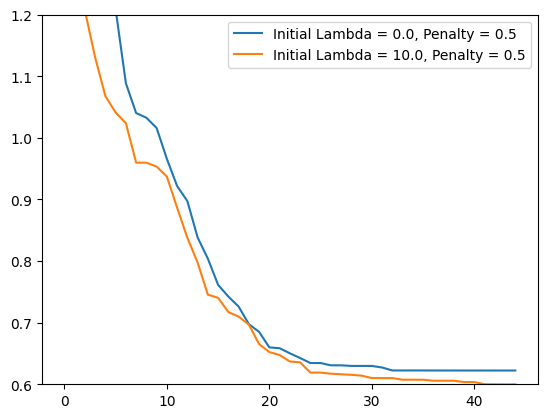

In [46]:
plt.plot(all_results_mean, label="Initial Lambda = 0.0, Penalty = 0.5")
plt.plot(updated_all_results_mean, label="Initial Lambda = 10.0, Penalty = 0.5")
# plt.plot(batch_all_results_mean, label="Batch = 3, Penalty Half")
# plt.plot(penalty_batch_all_results_mean, label="Batch = 3, Updated Proportional Penalty")
# plt.plot(larger_penalty_batch_all_results_mean, label="Batch = 3, Larger Initial Penalty")
# plt.plot(batch_one_all_results_mean, label="Batch = 1, Larger Initial Penalty")
# plt.plot(batch_one_automatic_penalty_all_results_mean, label="Batch = 1, Automatic Penalty")
# plt.plot(batch_three_automatic_penalty_all_results_mean, label="Batch = 3, Automatic Penalty")
plt.ylim(0.6, 1.2)
plt.legend()
plt.show()

In [36]:
updated_all_results

array([[1.19903319, 0.785924  , 0.785924  , 0.6047928 , 0.6047928 ,
        0.6047928 , 0.6047928 , 0.6047928 , 0.6047928 , 0.6047928 ,
        0.6047928 , 0.6047928 , 0.6047928 , 0.6047928 , 0.6047928 ,
        0.6047928 , 0.6047928 , 0.6047928 , 0.6047928 , 0.6047928 ,
        0.6047928 , 0.6047928 , 0.5999507 , 0.5999507 , 0.5999507 ,
        0.5999507 , 0.59979338, 0.59979338, 0.59979338, 0.59979338,
        0.59979338, 0.59979338, 0.59979338, 0.59979338, 0.59979338,
        0.59979338, 0.59979338, 0.59979338, 0.59979338, 0.59979338,
        0.59979338, 0.59979338, 0.59979338, 0.59979338, 0.59979338],
       [1.65863785, 1.65863785, 1.65863785, 1.02881925, 1.02881925,
        1.02881925, 1.02881925, 1.02881925, 1.02881925, 1.02881925,
        1.02881925, 1.02881925, 1.02881925, 0.82763929, 0.82763929,
        0.82763929, 0.82763929, 0.82763929, 0.78377511, 0.68859443,
        0.68859443, 0.68859443, 0.68859443, 0.68859443, 0.62077798,
        0.62077798, 0.60775199, 0.60775199, 0.6

In [63]:
batch_one_all_results

array([[1.76651844, 0.90552961, 0.90552961, 0.90552961, 0.90552961,
        0.90552961, 0.90552961, 0.90552961, 0.90552961, 0.90552961,
        0.90552961, 0.80797543, 0.80797543, 0.80797543, 0.62127363,
        0.62127363, 0.62127363, 0.62127363, 0.62127363, 0.62127363,
        0.60066944, 0.60066944, 0.60066944, 0.60018666, 0.60018666,
        0.6000849 , 0.59992676, 0.59992676, 0.59992676, 0.59992676,
        0.59992676, 0.59992676, 0.59980402, 0.59980402, 0.59980402,
        0.59980402, 0.59980402, 0.59980402, 0.59980402, 0.59980402,
        0.59980402, 0.59980402, 0.59980402, 0.59980402, 0.59980402],
       [1.76915179, 1.76915179, 1.76915179, 1.76915179, 1.76915179,
        1.76915179, 1.76915179, 1.76915179, 1.76915179, 0.62414451,
        0.62414451, 0.62414451, 0.62414451, 0.62414451, 0.62414451,
        0.62414451, 0.62414451, 0.60902628, 0.6001573 , 0.6001573 ,
        0.6001573 , 0.6001573 , 0.60003675, 0.60003675, 0.60003675,
        0.60003675, 0.60003675, 0.60003675, 0.6

### Plot Query Points on Objective

In [21]:
with open("results/31-01-23/run_16_data.pkl", "rb") as fp:
    data = pickle.load(fp)

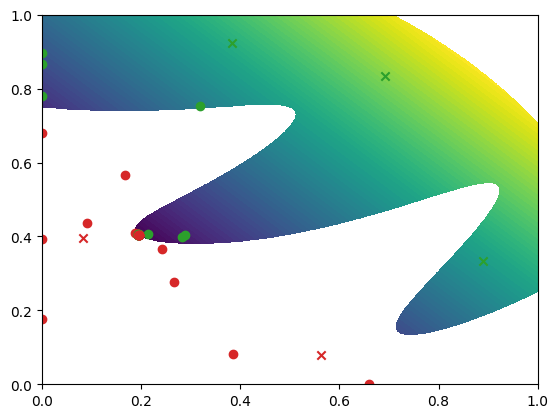

In [22]:
def masked_objective(x):
    mask_nan = np.logical_or(
        constraints.toy_constraint_one(x) > 0.0,
        constraints.toy_constraint_two(x) > 0.0,
    )
    y = np.array(objectives.linear_objective(x))
    y[mask_nan] = np.nan
    return tf.convert_to_tensor(y.reshape(-1, 1), x.dtype)


mask_fail1 = (
    data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().flatten() > 0
)
mask_fail2 = (
    data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().flatten() > 0
)
mask_fail = np.logical_or(mask_fail1, mask_fail2)

import matplotlib.pyplot as plt
from trieste.experimental.plotting import plot_function_2d, plot_bo_points

fig, ax = plot_function_2d(
    masked_objective,
    search_space.lower,
    search_space.upper,
    grid_density=1000,
    contour=True,
    fill=True,
)
plot_bo_points(
    data[OBJECTIVE].query_points.numpy(),
    ax=ax[0, 0],
    num_init=NUM_INITIAL_SAMPLES,
    mask_fail=mask_fail,
)
plt.show()

### Progression of Lambda Over Time

#### Initial Penalty = 8

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


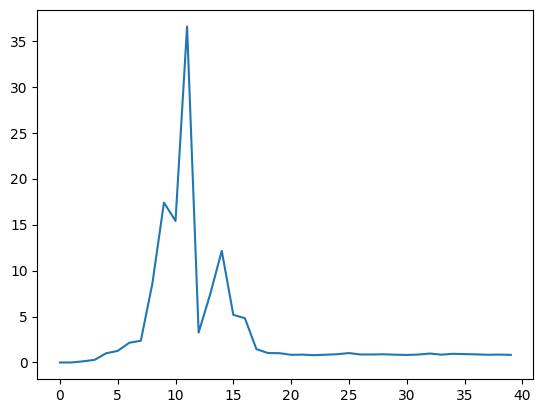

In [44]:
RUN = "two"

with open(f"results/08-02-23/penalty_8_lambda_0_0/run_{RUN}/inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)

with open(f"results/08-02-23/penalty_8_lambda_0_0/run_{RUN}/penalty_progression.pkl", "rb") as fp:
    penalty_progression = pickle.load(fp)

with open(f"results/08-02-23/penalty_8_lambda_0_0/run_{RUN}/datapoints.pkl", "rb") as fp:
    data = pickle.load(fp)

plt.plot(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])

In [45]:
for i in range(len(penalty_progression)):
    print(f"Iteration: {i} Penalty: {penalty_progression[i]} Lambda: {inequality_lambda[INEQUALITY_CONSTRAINT_ONE][i]} Ineq Cons One: {data[INEQUALITY_CONSTRAINT_ONE].observations[5:][i]}, Objective: {data[OBJECTIVE].observations[5:][i]}")

Iteration: 0 Penalty: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.0> Lambda: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0> Ineq Cons One: [-0.40950581], Objective: [1.23764966]
Iteration: 1 Penalty: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.0> Lambda: [[0.]] Ineq Cons One: [0.99671592], Objective: [0.28255401]
Iteration: 2 Penalty: 4.0 Lambda: [[0.12458949]] Ineq Cons One: [0.64489591], Objective: [0.46531928]
Iteration: 3 Penalty: 2.0 Lambda: [[0.28581347]] Ineq Cons One: [1.43171872], Objective: [0.14736714]
Iteration: 4 Penalty: 1.0 Lambda: [[1.00167283]] Ineq Cons One: [0.25957579], Objective: [0.43232853]
Iteration: 5 Penalty: 0.5 Lambda: [[1.26124862]] Ineq Cons One: [0.44189998], Objective: [0.38777642]
Iteration: 6 Penalty: 0.25 Lambda: [[2.14504858]] Ineq Cons One: [0.05610963], Objective: [0.74321986]
Iteration: 7 Penalty: 0.125 Lambda: [[2.3694871]] Ineq Cons One: [0.77781969], Objective: [0.70270954]
Iteration: 8 Penalty: 0.0625 

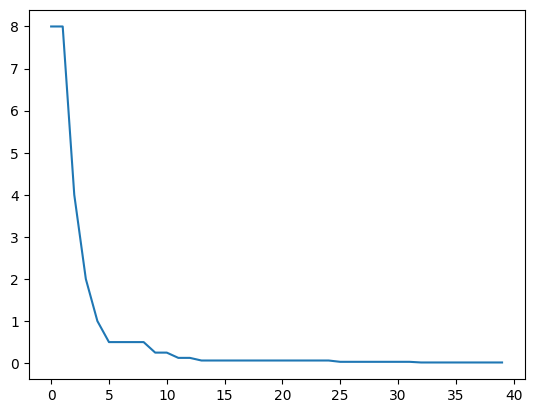

In [88]:
plt.plot(penalty_progression)

In [29]:
with open("results/08-02-23/run_three/datapoints.pkl", "rb") as fp:
    data = pickle.load(fp)

In [44]:
data[INEQUALITY_CONSTRAINT_ONE].observations[5:]

40

#### Initial Penalty = 0.5

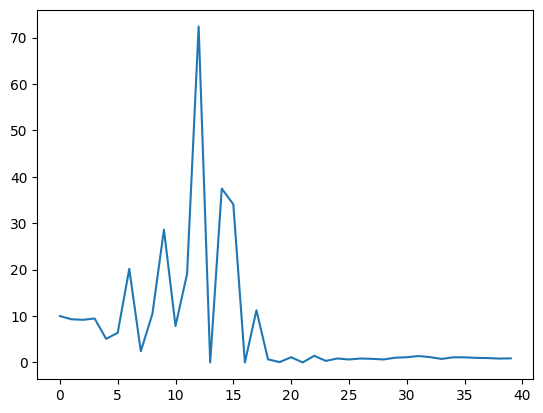

In [95]:
RUN = 19

with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{RUN}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)

with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{RUN}_penalty_progression.pkl", "rb") as fp:
    penalty_progression = pickle.load(fp)

with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{RUN}_data.pkl", "rb") as fp:
    data = pickle.load(fp)

plt.plot(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])

In [ ]:
for i in range(len(penalty_progression)):
    print(f"Iteration: {i} Penalty: {penalty_progression[i]} Lambda: {inequality_lambda[INEQUALITY_CONSTRAINT_ONE][i]} Ineq Cons One: {data[INEQUALITY_CONSTRAINT_ONE].observations[5:][i]}, Objective: {data[OBJECTIVE].observations[5:][i]}")

#### Automatic Penalty

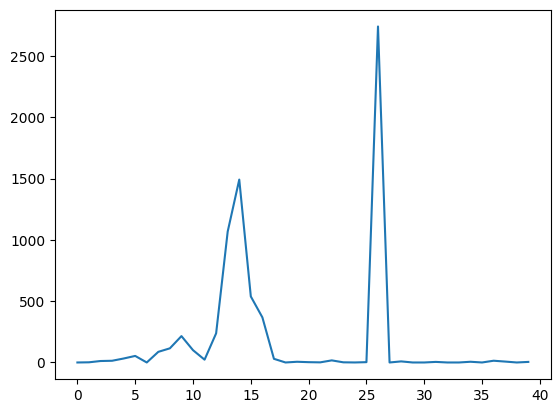

In [31]:
RUN = 8

with open(f"results/09-02-23/batch_1_automatic_penalty/run_{RUN}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)

with open(f"results/09-02-23/batch_1_automatic_penalty/run_{RUN}_penalty_progression.pkl", "rb") as fp:
    penalty_progression = pickle.load(fp)

with open(f"results/09-02-23/batch_1_automatic_penalty/run_{RUN}_data.pkl", "rb") as fp:
    data = pickle.load(fp)

plt.plot(tf.squeeze(inequality_lambda[INEQUALITY_CONSTRAINT_ONE]))

In [32]:
for i in range(len(penalty_progression)):
    print(f"Iteration: {i} Penalty: {penalty_progression[i]} Lambda: {inequality_lambda[INEQUALITY_CONSTRAINT_ONE][i]} Ineq Cons One: {data[INEQUALITY_CONSTRAINT_ONE].observations[5:][i]}, Objective: {data[OBJECTIVE].observations[5:][i]}")

Iteration: 0 Penalty: <tf.Variable 'Variable:0' shape=(1, 1, 1) dtype=float64, numpy=array([[[0.29544451]]])> Lambda: <tf.Variable 'Variable:0' shape=(1, 1, 1) dtype=float64, numpy=array([[[0.]]])> Ineq Cons One: [0.41947394], Objective: [0.72236867]
Iteration: 1 Penalty: [[[0.14772226]]] Lambda: [[[1.41980617]]] Ineq Cons One: [1.54962596], Objective: [0.01164716]
Iteration: 2 Penalty: [[[0.07386113]]] Lambda: [[[11.90993811]]] Ineq Cons One: [0.15085015], Objective: [0.77635976]
Iteration: 3 Penalty: [[[0.03693056]]] Lambda: [[[13.95228647]]] Ineq Cons One: [0.68009438], Objective: [0.69480114]
Iteration: 4 Penalty: [[[0.01846528]]] Lambda: [[[32.36777496]]] Ineq Cons One: [0.38927902], Objective: [0.93175301]
Iteration: 5 Penalty: [[[0.00923264]]] Lambda: [[[53.44944696]]] Ineq Cons One: [-0.77339934], Objective: [1.52224764]
Iteration: 6 Penalty: [[[0.00923264]]] Lambda: [[[0.]]] Ineq Cons One: [0.80094123], Objective: [0.27431741]
Iteration: 7 Penalty: [[[0.00461632]]] Lambda: [[[

### Batch Runs

In [137]:
run = 19

with open(f"results/09-02-23/batch_3_proportional_penalty/run_{run}_inequality_lambda_progression.pkl", "rb") as fp:
    inequality_lambda = pickle.load(fp)
a = tf.Variable(inequality_lambda[INEQUALITY_CONSTRAINT_ONE])
b = tf.transpose(tf.reshape(a, (14,3)))

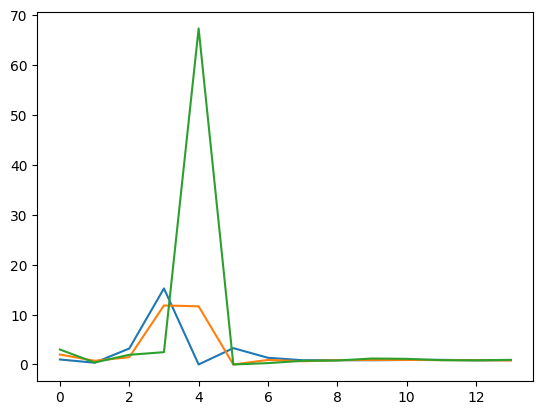

In [138]:
plt.plot(b[0])
plt.plot(b[1])
plt.plot(b[2])

### Second Experiment - Different Starting Lambda

In [3]:
for run in range(20):
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)


    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)
    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable(10.0, dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable(10.0, dtype=tf.float64)}
    initial_penalty = tf.Variable(0.5, dtype=tf.float64)

    save_path = f"results/08-02-23/penalty_0_5_lambda_10_10/run_{run}"
    augmented_lagrangian = UpdatedThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda, None,
                                                               initial_penalty, 0.001, search_space, save_lambda=True, save_path=save_path)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer())
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(40, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/08-02-23/penalty_0_5_lambda_10_10/run_{run}_data.pkl", 'wb') as fp:
        pickle.dump(data, fp)

NameError: name 'search_space' is not defined

### Experiment with Automatic Selection of Penalty

In [15]:
BATCH_SIZE = 3
NUM_BO_ITERS = 14

for run in range(18, 20):
    search_space = Box([0.0, 0.0], [1.0, 1.0])
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)
    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)

    constraint_one_satisfied = (tf.squeeze(initial_data[INEQUALITY_CONSTRAINT_ONE].observations) <= 0)
    constraint_two_satisfied = (tf.squeeze(initial_data[INEQUALITY_CONSTRAINT_TWO].observations) <= 0)
    all_satisfied = tf.logical_and(constraint_one_satisfied, constraint_two_satisfied)
    at_least_one_violated = tf.logical_not(all_satisfied)

    initial_penalty = None
    if tf.reduce_sum(tf.cast(at_least_one_violated, tf.int32)) == 0:
        # If valid everywhere, set initial penalty to one
        initial_penalty = 1
    else:
        invalid_ineq_one_squared = tf.square(tf.squeeze(initial_data[INEQUALITY_CONSTRAINT_ONE].observations)[at_least_one_violated])
        invalid_ineq_two_squared = tf.square(tf.squeeze(initial_data[INEQUALITY_CONSTRAINT_TWO].observations)[at_least_one_violated])
        sum_squared = invalid_ineq_one_squared + invalid_ineq_two_squared
        min_sum_squared = tf.math.reduce_min(sum_squared)
        if tf.reduce_sum(tf.cast(all_satisfied, tf.int32)) == 0:
            denominator = tfp.stats.percentile(initial_data[OBJECTIVE].observations, 50.0, interpolation='midpoint')
            initial_penalty = min_sum_squared / denominator
        else:
            best_valid_objective = tf.math.reduce_min(initial_data[OBJECTIVE].observations[all_satisfied])
            denominator = 2 * best_valid_objective
            initial_penalty = min_sum_squared / denominator

    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable([[[1.0], [2.0], [3.0]]], dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable([[[0.0], [0.0], [0.0]]], dtype=tf.float64)}
    print(f"Initial Penalty: {initial_penalty}")
    initial_penalty = tf.Variable([[[initial_penalty], [initial_penalty], [initial_penalty]]], dtype=tf.float64)
    print(f"Initial Penalty: {initial_penalty}")

    save_path = f"results/09-02-23/batch_3_automatic_penalty/run_{run}"
    augmented_lagrangian = BatchThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda,                                                                 None, BATCH_SIZE, initial_penalty, 0.001, search_space, True, save_path, NUM_BO_ITERS)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer(), num_query_points=BATCH_SIZE)
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(NUM_BO_ITERS, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/09-02-23/batch_3_automatic_penalty/run_{run}_data.pkl", "wb") as fp:
        pickle.dump(data, fp)

Initial Penalty: 0.1858112659698625
Initial Penalty: <tf.Variable 'Variable:0' shape=(1, 3, 1) dtype=float64, numpy=
array([[[0.18581127],
        [0.18581127],
        [0.18581127]]])>


2023-02-10 14:26:52.710289: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:26:54.951005: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:26:57.063236: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:03.083195: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:04.528106: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:05.776818: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[3.44899455],
        [5.14686185],
        [4.14596733]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 3.0
Not Satisfied. Updated Penalty: [[[0.02322641]
  [0.02322641]
  [0.02322641]]]
Objective X: [[0.89191966 0.13045466]
 [0.67590283 0.28659527]
 [0.01299327 0.39425866]] Value: [[1.02237431]
 [0.96249811]
 [0.40725192]]


2023-02-10 14:27:08.089113: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:09.323755: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:10.570529: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[52.85272339],
        [80.95774322],
        [48.50806601]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 3.0
Not Satisfied. Updated Penalty: [[[0.0029033]
  [0.0029033]
  [0.0029033]]]
Objective X: [[0.34529574 0.08650921]
 [0.         0.11884544]
 [0.31335427 0.03543659]] Value: [[0.43180494]
 [0.11884544]
 [0.34879086]]


2023-02-10 14:27:13.013349: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:14.263625: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:15.490853: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[197.06622818],
        [172.6157396 ],
        [132.23223667]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 3.0
Not Satisfied. Updated Penalty: [[[0.00036291]
  [0.00036291]
  [0.00036291]]]
Objective X: [[0.07244963 0.31908189]
 [0.         0.43525777]
 [0.25647811 0.3387634 ]] Value: [[0.39153152]
 [0.43525777]
 [0.59524151]]


2023-02-10 14:27:20.198552: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:21.448863: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:27.365167: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[1512.79453662],
        [1406.33124155],
        [ 594.92308099]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 3.0
Not Satisfied. Updated Penalty: [[[4.53640786e-05]
  [4.53640786e-05]
  [4.53640786e-05]]]
Objective X: [[0.         0.68766425]
 [0.         0.48772537]
 [0.08103661 0.37565942]] Value: [[0.68766425]
 [0.48772537]
 [0.45669604]]


2023-02-10 14:27:33.331722: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:34.547994: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:35.787300: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[-2.27373675e-13],
        [ 4.10062204e+03],
        [ 1.07840711e+03]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 2.0
Not Satisfied. Updated Penalty: [[[4.53640786e-05]
  [1.13410197e-05]
  [1.13410197e-05]]]
Objective X: [[0.00408157 0.87499592]
 [0.09924749 0.41940458]
 [0.70738829 0.16295739]] Value: [[0.87907749]
 [0.51865207]
 [0.87034568]]


2023-02-10 14:27:40.112301: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:41.341235: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:42.605222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[7.85465203e-14],
        [1.53344790e+03],
        [5.36080543e+02]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.25750133 0.43032665]
 [0.21547735 0.40919394]
 [0.21234264 0.45077005]] Value: [[0.68782797]
 [0.62467129]
 [0.6631127 ]]


2023-02-10 14:27:47.121535: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:48.376797: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:49.618737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[ 32.2118895],
        [415.1408027],
        [  0.       ]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.26820393e-05]
  [1.13410197e-05]
  [1.13410197e-05]]]
Objective X: [[0.19210708 0.40664164]
 [0.20024419 0.41162043]
 [0.20902887 0.40025116]] Value: [[0.59874873]
 [0.61186462]
 [0.60928003]]


2023-02-10 14:27:52.721778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:53.972526: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:27:55.196710: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[13.17875886],
        [19.25722884],
        [32.42217674]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19534099 0.40481858]
 [0.19846376 0.40518054]
 [0.19575174 0.40375594]] Value: [[0.60015957]
 [0.6036443 ]
 [0.59950768]]


2023-02-10 14:27:59.447914: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:00.696366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:01.923728: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19512858 0.40501279]
 [0.19483605 0.4052847 ]
 [0.19505488 0.40526156]] Value: [[0.60014137]
 [0.60012075]
 [0.60031644]]


2023-02-10 14:28:04.846320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:06.098371: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:07.344546: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[ 0.        ],
        [26.32058964],
        [ 0.        ]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19530411 0.40459457]
 [0.1940408  0.40552901]
 [0.19519367 0.40488954]] Value: [[0.59989868]
 [0.59956981]
 [0.60008321]]


2023-02-10 14:28:10.681446: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:11.932790: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:13.203245: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.       ],
        [0.3928191],
        [0.       ]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19486277 0.40496295]
 [0.19481615 0.4052381 ]
 [0.19538688 0.40455235]] Value: [[0.59982572]
 [0.60005425]
 [0.59993923]]


2023-02-10 14:28:15.678245: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:16.898004: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:18.139429: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[ 0.        ],
        [10.86043366],
        [16.41998047]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1954675  0.40438796]
 [0.19487312 0.40481417]
 [0.19494912 0.40467891]] Value: [[0.59985545]
 [0.59968729]
 [0.59962803]]


2023-02-10 14:28:20.726934: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:21.952829: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:23.171737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[ 0.        ],
        [ 9.66703022],
        [13.35313915]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19506579 0.404725  ]
 [0.19601767 0.40381698]
 [0.19575445 0.40408025]] Value: [[0.59979079]
 [0.59983465]
 [0.5998347 ]]
SAVING


2023-02-10 14:28:26.031017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:27.256809: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:33.122319: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors
Initial Penalty: 0.9167215001570994
Initial Penalty: <tf.Variable 'Variable:0' shape=(1, 3, 1) dtype=float64, numpy=
array([[[0.9167215],
        [0.9167215],
        [0.9167215]]])>


2023-02-10 14:28:34.527831: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:35.748214: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:36.979614: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:42.165227: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:43.428571: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:44.674437: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.41347263],
        [0.83936624],
        [2.45457808]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.        ],
        [0.24773444],
        [0.        ]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.9167215 ]
  [0.45836075]
  [0.9167215 ]]]
Objective X: [[0.01575583 0.99505788]
 [0.90637347 0.95162525]
 [0.         1.        ]] Value: [[1.0108137 ]
 [1.85799872]
 [1.        ]]


2023-02-10 14:28:46.419349: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:47.657111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:48.881777: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[1.15190486],
        [4.02499886],
        [1.26717676]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 2.0
Not Satisfied. Updated Penalty: [[[0.22918038]
  [0.11459019]
  [0.9167215 ]]]
Objective X: [[0.67157185 0.        ]
 [0.03580383 0.        ]
 [0.30793393 1.        ]] Value: [[0.67157185]
 [0.03580383]
 [1.30793393]]


2023-02-10 14:28:50.688218: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:51.916103: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:53.136181: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[2.22044605e-16],
        [0.00000000e+00],
        [3.22481665e-01]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.89762352]
 [0.         0.83494964]
 [0.15397543 0.86521208]] Value: [[0.89762352]
 [0.83494964]
 [1.01918751]]


2023-02-10 14:28:54.921645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:56.145229: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:28:57.368679: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[1.74231212],
        [2.49914301],
        [1.05693848]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 3.0
Not Satisfied. Updated Penalty: [[[0.02864755]
  [0.01432377]
  [0.11459019]]]
Objective X: [[0.         0.69923413]
 [0.         0.36078782]
 [0.         0.54361401]] Value: [[0.69923413]
 [0.36078782]
 [0.54361401]]


2023-02-10 14:28:59.354641: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:00.612886: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:01.846829: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[2.22044605e-16],
        [1.91031626e+01],
        [1.01850632e+01]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 2.0
Not Satisfied. Updated Penalty: [[[0.02864755]
  [0.00358094]
  [0.02864755]]]
Objective X: [[0.         0.76019017]
 [0.15474365 0.34221812]
 [0.         0.24444394]] Value: [[0.76019017]
 [0.49696177]
 [0.24444394]]


2023-02-10 14:29:03.816150: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:05.035172: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:06.265997: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[4.25579050e-01],
        [3.55271368e-15],
        [3.26123009e-03]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.01432377]
  [0.00358094]
  [0.02864755]]]
Objective X: [[0.18076275 0.41152041]
 [0.31726329 0.39912386]
 [0.         0.78614719]] Value: [[0.59228316]
 [0.71638715]
 [0.78614719]]


2023-02-10 14:29:08.091639: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:09.298949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:10.522002: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[1.10608362],
        [1.67564708],
        [1.08442327]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 3.0
Not Satisfied. Updated Penalty: [[[0.00179047]
  [0.00044762]
  [0.00358094]]]
Objective X: [[0.19327803 0.39905847]
 [0.19380177 0.40117885]
 [0.17489129 0.39834731]] Value: [[0.5923365 ]
 [0.59498062]
 [0.5732386 ]]


2023-02-10 14:29:12.748887: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:18.595094: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:19.846905: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.86404045],
        [0.61205785],
        [0.90864517]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19579684 0.40436974]
 [0.19315533 0.40735795]
 [0.19430071 0.40611531]] Value: [[0.60016658]
 [0.60051328]
 [0.60041602]]


2023-02-10 14:29:23.601675: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:25.724700: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:27.108186: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[1.06305991],
        [1.1256899 ],
        [0.86372469]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19543498 0.40406158]
 [0.1955665  0.40404086]
 [0.1954159  0.40451189]] Value: [[0.59949656]
 [0.59960736]
 [0.5999278 ]]


2023-02-10 14:29:29.305991: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:30.611690: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:31.976953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.87923504],
        [1.03371312],
        [0.80689486]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19547066 0.40460088]
 [0.19483719 0.40499112]
 [0.19530363 0.40465941]] Value: [[0.60007154]
 [0.59982831]
 [0.59996304]]


2023-02-10 14:29:34.227386: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:35.571768: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:36.887845: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.90863346],
        [1.0070975 ],
        [0.8634504 ]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19517733 0.40456588]
 [0.19466078 0.40514848]
 [0.19485491 0.40475974]] Value: [[0.59974321]
 [0.59980926]
 [0.59961465]]


2023-02-10 14:29:39.319692: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:40.662266: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:42.034109: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.89819852],
        [0.93496783],
        [0.85331834]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19519805 0.40460625]
 [0.19501514 0.40480149]
 [0.19517665 0.40464263]] Value: [[0.59980429]
 [0.59981663]
 [0.59981928]]


2023-02-10 14:29:44.536533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:45.906817: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:47.332377: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.99325058],
        [0.55782963],
        [0.84798901]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19714152 0.4026884 ]
 [0.19491258 0.405026  ]
 [0.19687557 0.40305617]] Value: [[0.59982992]
 [0.59993858]
 [0.59993175]]
SAVING


2023-02-10 14:29:51.386742: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:52.703322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 14:29:53.987869: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


### Batch Experiment

Penalty just halves when violated

In [57]:
BATCH_SIZE = 1
NUM_BO_ITERS = 40

for run in range(20):
    search_space = Box([0.0, 0.0], [1.0, 1.0])
    observer = trieste.objectives.utils.mk_multi_observer(
        OBJECTIVE=objectives.linear_objective,
        INEQUALITY_CONSTRAINT_ONE=constraints.toy_constraint_one,
        INEQUALITY_CONSTRAINT_TWO=constraints.toy_constraint_two)

    initial_inputs = search_space.sample(NUM_INITIAL_SAMPLES)
    initial_data = observer(initial_inputs)
    initial_models = trieste.utils.map_values(create_model, initial_data)

    inequality_lambda = {INEQUALITY_CONSTRAINT_ONE: tf.Variable([[[0.0]]], dtype=tf.float64),
                         INEQUALITY_CONSTRAINT_TWO: tf.Variable([[[0.0]]], dtype=tf.float64)}
    initial_penalty = tf.Variable([[[8.0]]], dtype=tf.float64)

    save_path = f"results/09-02-23/batch_1_proportional_penalty_initial_8/run_{run}"
    augmented_lagrangian = BatchThompsonSamplingAugmentedLagrangian(OBJECTIVE, "INEQUALITY", None, inequality_lambda,                                                                 None, BATCH_SIZE, initial_penalty, 0.001, search_space, True, save_path, NUM_BO_ITERS)

    rule = EfficientGlobalOptimization(augmented_lagrangian, optimizer=generate_continuous_optimizer(), num_query_points=BATCH_SIZE)
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
    data = bo.optimize(NUM_BO_ITERS, initial_data, initial_models, rule, track_state=True).try_get_final_datasets()
    with open(f"results/09-02-23/batch_1_proportional_penalty_initial_8/run_{run}_data.pkl", "wb") as fp:
        pickle.dump(data, fp)

2023-02-10 01:03:05.103775: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:06.533705: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:07.883368: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:13.119598: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:14.450475: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:15.733146: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.31561752 0.83242862]] Value: [[1.14804614]]


2023-02-10 01:03:17.368054: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:18.696438: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:23.042183: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.19607788]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.17347276 0.10471899]] Value: [[0.27819175]]


2023-02-10 01:03:24.664528: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:26.001131: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:27.379142: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.57107788]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0. 0.]] Value: [[0.]]


2023-02-10 01:03:28.915686: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:30.212656: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:31.619715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82107788]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[1. 0.]] Value: [[1.]]


2023-02-10 01:03:33.484871: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:35.408632: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:37.341336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.15383857]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.         0.45816677]] Value: [[0.45816677]]


2023-02-10 01:03:40.385468: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:43.430603: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:45.170210: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.69929131]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.         0.59047526]] Value: [[0.59047526]]


2023-02-10 01:03:47.160215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:48.774361: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:50.238973: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.9039247]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.80797543]] Value: [[0.80797543]]


2023-02-10 01:03:51.860244: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:53.193028: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:54.552695: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.9235907]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.1894561  0.43131815]] Value: [[0.62077425]]


2023-02-10 01:03:56.218451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:03:57.543386: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:02.149410: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.34237343]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.1267004  0.46242345]] Value: [[0.58912385]]


2023-02-10 01:04:03.878145: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:05.220295: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:06.539488: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.33568586]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.23365178 0.38762185]] Value: [[0.62127363]]


2023-02-10 01:04:08.256891: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:09.565573: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:10.881374: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[5.69465623]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.32369093 0.34789299]] Value: [[0.67158392]]


2023-02-10 01:04:12.693221: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:14.020825: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:15.342297: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.9737185]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.76028701]] Value: [[0.76028701]]


2023-02-10 01:04:17.057492: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:18.373066: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:19.747230: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.91781157]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.17176796 0.40263198]] Value: [[0.57439994]]


2023-02-10 01:04:21.597080: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:22.921724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:24.283688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82744064]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.22741603 0.41366625]] Value: [[0.64108228]]


2023-02-10 01:04:26.049163: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:27.361594: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:28.671982: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90835294]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.19382067 0.40488755]] Value: [[0.59870823]]


2023-02-10 01:04:30.402422: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:34.678684: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:36.027776: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.7778414]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19619118 0.40447826]] Value: [[0.60066944]]


2023-02-10 01:04:37.741645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:39.030644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:40.367200: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86036769]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19381553 0.40545423]] Value: [[0.59926976]]


2023-02-10 01:04:42.159799: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:43.495804: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:44.877582: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91897715]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19309079 0.40646367]] Value: [[0.59955445]]


2023-02-10 01:04:46.849159: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:48.166179: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:49.533051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85993419]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19524816 0.40493849]] Value: [[0.60018666]]


2023-02-10 01:04:51.269554: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:52.600430: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:53.934143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92428019]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19661825 0.40288201]] Value: [[0.59950026]]


2023-02-10 01:04:55.847518: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:57.178257: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:04:58.516700: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88129532]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1957871  0.40429781]] Value: [[0.6000849]]


2023-02-10 01:05:00.488104: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:01.791356: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:03.119525: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86078919]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19509531 0.40483145]] Value: [[0.59992676]]


2023-02-10 01:05:05.140121: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:09.583859: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:10.887706: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86995385]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19611843 0.40365648]] Value: [[0.59977491]]


2023-02-10 01:05:12.651038: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:14.029370: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:15.382919: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89214323]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.195952   0.40372751]] Value: [[0.59967951]]


2023-02-10 01:05:17.142927: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:18.434482: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:19.765845: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87022625]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19410646 0.40589709]] Value: [[0.60000355]]


2023-02-10 01:05:21.563112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:22.880149: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:24.214150: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87987113]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19363831 0.40619528]] Value: [[0.59983359]]


2023-02-10 01:05:26.021858: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:27.330196: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:28.655552: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85964175]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19607922 0.40387643]] Value: [[0.59995564]]


2023-02-10 01:05:30.392312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:31.691260: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:32.996030: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8583518]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19474466 0.40505936]] Value: [[0.59980402]]


2023-02-10 01:05:34.720838: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:36.053263: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:37.377718: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8464775]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1949178  0.40495361]] Value: [[0.59987141]]


2023-02-10 01:05:39.197901: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:43.670542: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


2023-02-10 01:05:44.960677: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8384311]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19448377 0.40538196]] Value: [[0.59986573]]


2023-02-10 01:05:46.699641: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:48.018051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:49.342034: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82830799]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19521414 0.40464195]] Value: [[0.59985609]]


2023-02-10 01:05:51.137489: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:52.457066: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:53.784753: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85602128]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19510962 0.40449328]] Value: [[0.5996029]]


2023-02-10 01:05:55.577277: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:56.871502: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:05:58.195307: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84414205]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19527943 0.40458878]] Value: [[0.59986821]]


2023-02-10 01:06:00.005707: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:01.316357: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:02.676941: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85742352]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19458808 0.40512122]] Value: [[0.5997093]]


2023-02-10 01:06:04.477312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:05.811593: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:07.143232: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89497203]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19576486 0.40380367]] Value: [[0.59956853]]


2023-02-10 01:06:08.934477: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:10.255694: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:11.728388: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8857954]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19370443 0.40626236]] Value: [[0.59996679]]


2023-02-10 01:06:16.847340: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:18.169705: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:19.514217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90097265]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19630153 0.40345409]] Value: [[0.59975562]]


2023-02-10 01:06:21.228428: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:22.539394: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:23.878519: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84919725]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19523782 0.40489946]] Value: [[0.60013728]]


2023-02-10 01:06:25.636685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:26.938743: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:28.279249: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86558587]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19611525 0.40361455]] Value: [[0.5997298]]
SAVING


2023-02-10 01:06:29.990832: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:31.297902: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:32.633619: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:06:34.114196: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:35.487629: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:36.841621: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:42.212381: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:43.561181: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:44.902696: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.0629244]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.63263233 0.20859903]] Value: [[0.84123136]]


2023-02-10 01:06:49.873469: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:51.238438: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:52.565602: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.23907735]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.         0.55357477]] Value: [[0.55357477]]


2023-02-10 01:06:54.199681: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:55.523214: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:56.837984: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.0448358]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.12578365 0.13129841]] Value: [[0.25708206]]


2023-02-10 01:06:58.449524: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:06:59.771755: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:01.106488: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.40258034]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.2819087  0.59853142]] Value: [[0.88044011]]


2023-02-10 01:07:02.703537: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:04.077715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:05.400032: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.34589184]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.217151   0.40699351]] Value: [[0.62414451]]


2023-02-10 01:07:06.973864: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:08.270957: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:09.600967: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.64148037]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.66163977 0.        ]] Value: [[0.66163977]]


2023-02-10 01:07:11.210172: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:12.521185: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:13.840895: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.90215449]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.17964438 0.3277642 ]] Value: [[0.50740857]]


2023-02-10 01:07:15.471769: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:16.769904: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:18.106583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.02921293]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.27647325 0.41653992]] Value: [[0.69301317]]


2023-02-10 01:07:19.721704: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:24.188774: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:25.507418: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.91354539]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.34702842 0.40932705]] Value: [[0.75635547]]


2023-02-10 01:07:27.102868: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:28.399404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:29.720070: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.08982548]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.27963132 0.41177339]] Value: [[0.69140471]]


2023-02-10 01:07:31.356831: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:32.674900: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:34.020375: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.79502776]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21834248 0.41346656]] Value: [[0.63180904]]


2023-02-10 01:07:36.084969: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:38.449159: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:39.848979: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.03243373]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.17326507 0.40084182]] Value: [[0.57410689]]


2023-02-10 01:07:41.549608: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:42.920065: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:44.263184: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86009151]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20283288 0.4061934 ]] Value: [[0.60902628]]


2023-02-10 01:07:46.036807: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:47.438056: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:48.785575: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85567885]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1970965 0.4030608]] Value: [[0.6001573]]


2023-02-10 01:07:50.520543: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:51.944028: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:53.271357: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86388673]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19519441 0.40416166]] Value: [[0.59935607]]


2023-02-10 01:07:58.163487: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:07:59.452119: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:00.756860: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86586547]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19593627 0.40378182]] Value: [[0.59971809]]


2023-02-10 01:08:02.423788: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:03.722088: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:05.056993: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87130295]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19696166 0.40271316]] Value: [[0.59967482]]


2023-02-10 01:08:06.743597: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:08.054598: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:09.377212: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86688164]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19484828 0.40518848]] Value: [[0.60003675]]


2023-02-10 01:08:11.009256: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:12.338411: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:13.655139: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86790936]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1938848  0.40592293]] Value: [[0.59980773]]


2023-02-10 01:08:15.372264: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:16.725993: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:18.038452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84779158]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19726253 0.40367199]] Value: [[0.60093452]]


2023-02-10 01:08:19.668574: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:20.972021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:22.288105: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85079326]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19529996 0.40433138]] Value: [[0.59963134]]


2023-02-10 01:08:23.944569: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:25.239802: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:26.600131: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85174242]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19491305 0.40482535]] Value: [[0.5997384]]


2023-02-10 01:08:28.194217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:32.632754: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:33.961940: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[5.25865534]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.         0.36446963]] Value: [[0.36446963]]


2023-02-10 01:08:35.613400: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:36.948611: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:38.283228: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84682655]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.28794563 0.4272642 ]] Value: [[0.71520983]]


2023-02-10 01:08:39.956971: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:41.262588: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:42.593121: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87990607]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.19346056 0.40548146]] Value: [[0.59894202]]


2023-02-10 01:08:44.291760: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:45.586823: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:46.947180: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86700397]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19629857 0.40370962]] Value: [[0.60000819]]


2023-02-10 01:08:48.636757: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:49.963750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:51.275931: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88101293]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19453802 0.40507081]] Value: [[0.59960883]]


2023-02-10 01:08:53.148638: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:54.483697: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:55.802894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86019961]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19576759 0.40430774]] Value: [[0.60007534]]


2023-02-10 01:08:57.769272: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:08:59.081912: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:00.398607: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87105037]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19478343 0.40486114]] Value: [[0.59964457]]


2023-02-10 01:09:02.271571: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:06.741593: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:08.056397: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86708465]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19501963 0.40482274]] Value: [[0.59984238]]


2023-02-10 01:09:09.745089: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:11.043292: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:12.359868: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86912454]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19493431 0.40482766]] Value: [[0.59976197]]


2023-02-10 01:09:14.090102: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:15.442498: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:16.768711: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87238122]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19529562 0.40445075]] Value: [[0.59974637]]


2023-02-10 01:09:18.484574: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:19.787895: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:21.111569: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87633956]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19435849 0.40540258]] Value: [[0.59976107]]


2023-02-10 01:09:22.781830: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:24.077784: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:25.411560: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85301881]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19464307 0.40548625]] Value: [[0.60012932]]


2023-02-10 01:09:27.108239: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:28.412879: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:29.729713: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87452257]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19458163 0.40492188]] Value: [[0.59950351]]


2023-02-10 01:09:31.430704: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:32.718852: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:34.019607: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85098626]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19492529 0.40518953]] Value: [[0.60011482]]


2023-02-10 01:09:35.714304: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:37.043674: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:41.541581: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85889723]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1944853  0.40521145]] Value: [[0.59969675]]


2023-02-10 01:09:43.206070: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:44.516560: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:45.816348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85958582]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19544913 0.40433486]] Value: [[0.59978399]]


2023-02-10 01:09:47.567484: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:48.863521: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:50.176670: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86525043]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1944206  0.40531181]] Value: [[0.59973241]]
SAVING


2023-02-10 01:09:52.064604: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:53.396527: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:54.715339: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:09:56.214878: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:57.570828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:09:58.933586: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:04.224484: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:05.578593: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:06.939885: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.21317783]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.         0.14176267]] Value: [[0.14176267]]


2023-02-10 01:10:08.570634: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:09.900627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:11.221511: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.29940562]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.14206522 0.51176284]] Value: [[0.65382806]]


2023-02-10 01:10:16.184758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:17.521205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:18.844035: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.38697863]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.11473785 0.45558276]] Value: [[0.57032061]]


2023-02-10 01:10:20.491688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:21.814777: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:23.145736: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.81022576]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.05838706 0.32000389]] Value: [[0.37839095]]


2023-02-10 01:10:24.783989: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:26.100894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:27.427366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92828437]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.16710767 0.38700699]] Value: [[0.55411466]]


2023-02-10 01:10:29.023657: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:30.332693: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:31.664990: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.78449048]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21806317 0.41283322]] Value: [[0.63089639]]


2023-02-10 01:10:33.342529: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:34.662917: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:36.012054: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.19771953]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.11695495 0.39184087]] Value: [[0.50879581]]


2023-02-10 01:10:37.645664: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:38.982681: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:40.314685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92309619]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.22287723 0.40663768]] Value: [[0.6295149]]


2023-02-10 01:10:41.921989: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:43.238452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:44.545770: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86764496]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20006469 0.40567318]] Value: [[0.60573787]]


2023-02-10 01:10:46.167571: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:50.747791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:52.030643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88354703]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.19332465 0.40476009]] Value: [[0.59808474]]


2023-02-10 01:10:53.692185: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:55.009383: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:56.366283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90636382]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.19327778 0.40531746]] Value: [[0.59859524]]


2023-02-10 01:10:58.038491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:10:59.350124: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:00.700107: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89026562]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19355223 0.40688078]] Value: [[0.60043301]]


2023-02-10 01:11:02.397574: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:03.719346: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:05.060315: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86256821]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.196435   0.40411825]] Value: [[0.60055325]]


2023-02-10 01:11:06.703348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:08.036866: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:09.364134: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87107747]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19513449 0.40442692]] Value: [[0.59956141]]


2023-02-10 01:11:11.028000: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:12.327506: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:13.662909: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89885153]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19213631 0.40723509]] Value: [[0.5993714]]


2023-02-10 01:11:15.321038: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:16.661208: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:18.002953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85572571]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19669094 0.40427131]] Value: [[0.60096225]]


2023-02-10 01:11:19.646008: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:20.935303: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:25.414908: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82932181]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19619961 0.40430819]] Value: [[0.6005078]]


2023-02-10 01:11:27.038793: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:28.352388: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:29.653281: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87103563]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.19317348 0.40554587]] Value: [[0.59871935]]


2023-02-10 01:11:31.365535: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:32.677438: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:34.011347: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84051382]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19396345 0.40635766]] Value: [[0.60032111]]


2023-02-10 01:11:35.710944: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:37.009159: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:38.369816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83919924]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19479138 0.40502021]] Value: [[0.59981159]]


2023-02-10 01:11:40.042644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:41.342894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:42.682194: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.94299782]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.19682027 0.40189659]] Value: [[0.59871686]]


2023-02-10 01:11:44.476084: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:45.789579: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:47.110796: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85834217]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19540419 0.40495422]] Value: [[0.60035841]]


2023-02-10 01:11:48.863784: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:50.146777: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:51.470779: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86855325]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19532062 0.40440191]] Value: [[0.59972253]]


2023-02-10 01:11:53.148493: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:54.432724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:11:55.749444: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[29.66050672]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.         0.39717617]] Value: [[0.39717617]]


2023-02-10 01:12:01.045057: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:02.363527: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:03.696668: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.74039973]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.2750608  0.41741628]] Value: [[0.69247708]]


2023-02-10 01:12:05.546660: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:06.870965: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:08.196090: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8873905]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19781457 0.40483952]] Value: [[0.60265409]]


2023-02-10 01:12:09.962718: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:11.292669: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:12.623680: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89324951]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1936901  0.40618634]] Value: [[0.59987644]]


2023-02-10 01:12:14.575194: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:15.912099: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:17.233694: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8883849]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19420912 0.40563958]] Value: [[0.5998487]]


2023-02-10 01:12:19.092769: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:20.393221: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:21.716619: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86897125]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19562178 0.40424055]] Value: [[0.59986233]]


2023-02-10 01:12:23.464673: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:24.774433: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:26.128078: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83860884]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19615297 0.40377666]] Value: [[0.59992963]]


2023-02-10 01:12:27.992453: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:29.319585: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:30.630892: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87084431]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19414319 0.40557712]] Value: [[0.59972031]]


2023-02-10 01:12:32.481812: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:37.049023: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:38.359248: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.93671604]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19658391 0.40309786]] Value: [[0.59968178]]


2023-02-10 01:12:40.127778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:41.443564: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:42.746787: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85992992]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1954264  0.40461984]] Value: [[0.60004624]]


2023-02-10 01:12:44.532546: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:45.828604: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:47.158678: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85859145]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19511391 0.40467864]] Value: [[0.59979255]]


2023-02-10 01:12:49.211432: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:50.531816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:51.863241: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85725744]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19533844 0.4044562 ]] Value: [[0.59979464]]


2023-02-10 01:12:53.653377: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:54.948000: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:56.308010: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86604173]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19450974 0.40526611]] Value: [[0.59977586]]


2023-02-10 01:12:58.210440: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:12:59.563963: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:00.861287: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90241887]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19399353 0.40572709]] Value: [[0.59972063]]


2023-02-10 01:13:02.636815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:03.952040: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:05.257106: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86329768]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19483995 0.40508709]] Value: [[0.59992704]]


2023-02-10 01:13:07.270711: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:08.597246: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:09.900920: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87087968]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19478442 0.40498308]] Value: [[0.5997675]]
SAVING


2023-02-10 01:13:11.699253: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:16.424337: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:17.717020: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:13:19.246497: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:20.604392: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:21.969327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:27.315298: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:28.682894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:30.033652: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.08727355]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.02533019 0.56105772]] Value: [[0.58638791]]


2023-02-10 01:13:31.683304: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:33.028084: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:34.349610: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.02055084]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.52863325 0.64937922]] Value: [[1.17801247]]


2023-02-10 01:13:35.997485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:37.295885: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:38.610680: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.0910885]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.04956908 0.45980663]] Value: [[0.50937571]]


2023-02-10 01:13:40.247311: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:41.547228: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:42.850347: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.20559398]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.         0.41191609]] Value: [[0.41191609]]


2023-02-10 01:13:44.432129: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:45.718877: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:50.333481: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.33305743]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.         0.23453813]] Value: [[0.23453813]]


2023-02-10 01:13:51.908409: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:53.237492: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:54.582442: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.60664469]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.41804436 0.        ]] Value: [[0.41804436]]


2023-02-10 01:13:56.258042: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:57.548230: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:13:58.847736: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.       0.845959]] Value: [[0.845959]]


2023-02-10 01:14:00.356124: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:01.647942: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:02.973117: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[6.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0. 0.]] Value: [[0.]]


2023-02-10 01:14:04.614294: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:05.924386: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:07.220462: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.54780523]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.01458308 0.84791925]] Value: [[0.86250234]]


2023-02-10 01:14:08.953519: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:10.262514: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:11.558618: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[5.04122097]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.         0.67373181]] Value: [[0.67373181]]


2023-02-10 01:14:13.365524: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:14.696714: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:16.008855: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.48605123]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.78523544]] Value: [[0.78523544]]


2023-02-10 01:14:17.843087: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:19.165828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:20.471336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.1031654]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75288951]] Value: [[0.75288951]]


2023-02-10 01:14:22.287667: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:26.915293: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:28.211584: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.16776368]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.         0.74951258]] Value: [[0.74951258]]


2023-02-10 01:14:29.874884: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:31.175003: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:32.510541: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-1.38777878e-16]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.25722202 0.41476334]] Value: [[0.67198536]]


2023-02-10 01:14:34.228886: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:35.544111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:36.867232: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.56911012]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.15002614 0.38488175]] Value: [[0.53490789]]


2023-02-10 01:14:38.534718: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:39.863968: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:41.182645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84473057]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20971489 0.41496444]] Value: [[0.62467932]]


2023-02-10 01:14:42.901968: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:44.190397: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:45.511111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.43282787]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.19521856 0.39812273]] Value: [[0.59334129]]


2023-02-10 01:14:47.445274: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:48.742376: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:50.107341: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.06179119]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19558838 0.4068369 ]] Value: [[0.60242528]]


2023-02-10 01:14:51.845154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:53.160989: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:54.484198: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87761537]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19631625 0.40470942]] Value: [[0.60102567]]


2023-02-10 01:14:56.219985: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:57.504742: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:14:58.840088: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.81983109]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19580979 0.40437232]] Value: [[0.60018211]]


2023-02-10 01:15:04.154746: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:05.444004: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:06.759853: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88138229]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19417191 0.40522087]] Value: [[0.59939279]]


2023-02-10 01:15:08.490623: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:09.811513: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:11.119593: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.897068]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1944915  0.40520586]] Value: [[0.59969736]]


2023-02-10 01:15:12.854779: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:14.163691: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:15.484219: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84511471]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19518315 0.40495644]] Value: [[0.60013959]]


2023-02-10 01:15:17.183673: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:18.479940: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:19.833031: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87709623]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19402589 0.40559051]] Value: [[0.5996164]]


2023-02-10 01:15:21.532156: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:22.866798: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:24.177689: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86013932]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19475039 0.40516241]] Value: [[0.59991279]]


2023-02-10 01:15:25.963260: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:27.266533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:28.599268: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88170351]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19435579 0.40530833]] Value: [[0.59966412]]


2023-02-10 01:15:30.441737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:31.782606: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:33.084668: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85639523]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19590675 0.40406992]] Value: [[0.59997667]]


2023-02-10 01:15:35.087106: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:36.402843: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:41.120827: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82995722]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19553677 0.4044321 ]] Value: [[0.59996887]]


2023-02-10 01:15:42.785447: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:44.092469: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:45.392157: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88125197]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19438261 0.4050709 ]] Value: [[0.59945352]]


2023-02-10 01:15:47.139038: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:48.414019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:49.736577: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84805239]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19519606 0.40481558]] Value: [[0.60001164]]


2023-02-10 01:15:51.537307: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:52.866664: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:54.186336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86603004]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19471624 0.40495561]] Value: [[0.59967185]]


2023-02-10 01:15:55.935949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:57.236961: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:15:58.559435: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85825607]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19445608 0.40540971]] Value: [[0.59986579]]


2023-02-10 01:16:00.377719: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:01.682252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:03.009092: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85588569]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19487657 0.40493068]] Value: [[0.59980725]]


2023-02-10 01:16:04.720275: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:06.029650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:07.369195: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88009529]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19381374 0.40588404]] Value: [[0.59969778]]


2023-02-10 01:16:09.155404: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:10.476466: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:11.775754: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87994123]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19438664 0.40542996]] Value: [[0.5998166]]


2023-02-10 01:16:13.557823: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:14.886720: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:16.398527: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88930027]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19413596 0.40563419]] Value: [[0.59977014]]


2023-02-10 01:16:21.696839: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:23.017182: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:24.326642: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85708385]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19506559 0.40494161]] Value: [[0.60000719]]


2023-02-10 01:16:26.199921: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:27.512841: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:28.815176: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84777499]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19466449 0.40519906]] Value: [[0.59986354]]


2023-02-10 01:16:30.607435: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:31.904156: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:33.235165: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84516338]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19647945 0.40340398]] Value: [[0.59988343]]
SAVING


2023-02-10 01:16:35.022420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:36.319260: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:37.636676: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:16:39.123582: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:40.518504: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:41.881652: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:47.171605: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:48.540816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:49.862768: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.18555469]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.16465954 0.16338318]] Value: [[0.32804272]]


2023-02-10 01:16:51.544968: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:52.884134: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:16:57.613290: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.31333383]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.07739093 0.52549499]] Value: [[0.60288592]]


2023-02-10 01:16:59.166378: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:00.474414: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:01.825160: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.66126806 1.        ]] Value: [[1.66126806]]


2023-02-10 01:17:03.417716: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:04.732244: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:06.081658: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.11907763]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.         0.38184727]] Value: [[0.38184727]]


2023-02-10 01:17:07.686436: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:08.992728: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:10.329436: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.48187989]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.         0.34103145]] Value: [[0.34103145]]


2023-02-10 01:17:11.998793: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:13.301226: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:14.640395: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.6020483]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.28640577 0.29965676]] Value: [[0.58606253]]


2023-02-10 01:17:16.302465: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:17.630920: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:18.982387: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[5.43837934]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.28954696 0.        ]] Value: [[0.28954696]]


2023-02-10 01:17:20.739363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:22.068808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:23.394758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.10275594]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.        0.8478676]] Value: [[0.8478676]]


2023-02-10 01:17:25.070990: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:26.382283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:27.678934: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.59569574]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.14281681 0.41417905]] Value: [[0.55699586]]


2023-02-10 01:17:29.300145: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:30.577133: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:35.467790: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92376153]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.17808773 0.40422064]] Value: [[0.58230837]]


2023-02-10 01:17:37.110254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:38.393294: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:39.719748: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90790063]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19098536 0.41086019]] Value: [[0.60184554]]


2023-02-10 01:17:41.368091: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:42.669702: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:43.990500: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92812329]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19168945 0.4081203 ]] Value: [[0.59980975]]


2023-02-10 01:17:45.654769: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:46.946559: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:48.279001: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85685222]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19605692 0.40566805]] Value: [[0.60172497]]


2023-02-10 01:17:49.898938: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:51.200947: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:52.512461: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8296923]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19579213 0.40472556]] Value: [[0.60051768]]


2023-02-10 01:17:54.206852: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:55.521914: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:56.835910: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83250221]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19407404 0.40568877]] Value: [[0.59976281]]


2023-02-10 01:17:58.480974: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:17:59.789957: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:01.114618: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[16.3554218]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.57115384 0.        ]] Value: [[0.57115384]]


2023-02-10 01:18:02.987282: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:04.311329: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:05.651715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[38.59381488]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.         0.70642313]] Value: [[0.70642313]]


2023-02-10 01:18:07.407881: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:12.218132: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:13.557265: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.00626467 0.80875498]] Value: [[0.81501966]]


2023-02-10 01:18:15.270465: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:16.569020: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:17.898662: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.96060098]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.19175122 0.40175333]] Value: [[0.59350455]]


2023-02-10 01:18:19.724692: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:21.051897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:22.389916: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88073529]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19530963 0.40474666]] Value: [[0.6000563]]


2023-02-10 01:18:24.163165: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:25.484471: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:26.810886: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87790858]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19527753 0.40452103]] Value: [[0.59979856]]


2023-02-10 01:18:28.863951: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:30.189468: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:31.531426: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82590153]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1949912  0.40497528]] Value: [[0.59996647]]


2023-02-10 01:18:33.724451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:35.196173: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:36.538380: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92916143]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19362888 0.40588861]] Value: [[0.59951749]]


2023-02-10 01:18:38.408616: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:39.743120: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:41.064682: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84705809]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19531903 0.40474477]] Value: [[0.6000638]]


2023-02-10 01:18:43.097618: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:44.416268: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:45.741991: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8743743]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19581475 0.40390821]] Value: [[0.59972295]]


2023-02-10 01:18:47.610457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:48.919619: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:53.856831: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.79434856]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19550589 0.40455203]] Value: [[0.60005792]]


2023-02-10 01:18:56.033750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:57.359285: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:18:58.697243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91659591]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19517634 0.40420855]] Value: [[0.59938489]]


2023-02-10 01:19:00.495533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:01.832938: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:03.151251: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85579771]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19546853 0.40452509]] Value: [[0.59999362]]


2023-02-10 01:19:04.935344: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:06.252588: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:07.565925: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82352303]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19502728 0.40487084]] Value: [[0.59989812]]


2023-02-10 01:19:09.605203: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:10.931907: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:12.271695: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8535526]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19486928 0.4048193 ]] Value: [[0.59968858]]


2023-02-10 01:19:14.113617: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:15.474689: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:16.801292: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.08850274]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19310806 0.40598828]] Value: [[0.59909634]]


2023-02-10 01:19:18.828853: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:20.159131: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:21.498564: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[14.7904127]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00195312]]]
Objective X: [[0.15761944 0.43102051]] Value: [[0.58863995]]


2023-02-10 01:19:23.415252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:24.739943: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:26.078158: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.14937615]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21435267 0.40821086]] Value: [[0.62256354]]


2023-02-10 01:19:28.024044: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:29.334746: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:34.239533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.93965123]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19455158 0.4056272 ]] Value: [[0.60017877]]


2023-02-10 01:19:36.173145: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:37.472908: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:38.810728: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.93683136]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19551945 0.40428048]] Value: [[0.59979992]]


2023-02-10 01:19:40.770724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:42.084979: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:43.415452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8458064]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19508971 0.40485244]] Value: [[0.59994214]]


2023-02-10 01:19:45.232965: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:46.556331: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:47.909412: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85246577]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19464977 0.40513773]] Value: [[0.59978751]]


2023-02-10 01:19:49.829105: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:51.156341: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:52.476683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8555982]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19448792 0.40531483]] Value: [[0.59980274]]


2023-02-10 01:19:54.402523: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:55.757679: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:19:57.096041: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.97359907]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19637211 0.40330407]] Value: [[0.59967618]]
SAVING


2023-02-10 01:19:58.975750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:00.309424: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:01.610325: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:20:03.135493: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:04.490871: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:05.831631: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:14.968901: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:16.342735: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:17.678418: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.16003075]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.19270926 0.02092515]] Value: [[0.21363442]]


2023-02-10 01:20:19.308799: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:20.634835: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:21.946154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.56754996]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.        0.1604979]] Value: [[0.1604979]]


2023-02-10 01:20:23.596377: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:24.905974: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:26.264310: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87437723]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.         0.52731748]] Value: [[0.52731748]]


2023-02-10 01:20:27.872390: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:29.175233: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:30.490230: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.4988982]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.79742184]] Value: [[0.79742184]]


2023-02-10 01:20:32.099411: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:33.444917: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:34.795142: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.40726787]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.76108941]] Value: [[0.76108941]]


2023-02-10 01:20:36.397946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:37.718318: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:39.008897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.6290524]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.06954999 0.44911226]] Value: [[0.51866224]]


2023-02-10 01:20:40.665479: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:41.975102: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:43.312136: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.6290524]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0. 0.]] Value: [[0.]]


2023-02-10 01:20:44.911894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:46.205699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:51.057403: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.30085974]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.05985905 0.82069017]] Value: [[0.88054922]]


2023-02-10 01:20:52.680695: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:54.018226: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:55.334769: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.11352065]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.78682192]] Value: [[0.78682192]]


2023-02-10 01:20:56.937545: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:58.230640: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:20:59.614377: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.05258841]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.         0.41761474]] Value: [[0.41761474]]


2023-02-10 01:21:01.284752: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:02.597432: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:03.938647: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.04453472]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.15693588 0.36735667]] Value: [[0.52429254]]


2023-02-10 01:21:05.685425: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:07.014565: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:08.329880: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.12363568]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.76455542]] Value: [[0.76455542]]


2023-02-10 01:21:09.974173: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:11.275761: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:12.606215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.66923511]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.11597955 0.40103094]] Value: [[0.51701049]]


2023-02-10 01:21:14.445732: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:15.770294: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:17.092833: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.43681057]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1997399  0.40630202]] Value: [[0.60604192]]


2023-02-10 01:21:18.739735: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:20.044163: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:21.368541: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.28890126]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21417724 0.39535404]] Value: [[0.60953128]]


2023-02-10 01:21:23.173570: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:24.475744: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:25.792578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85618605]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20407833 0.40733128]] Value: [[0.61140962]]


2023-02-10 01:21:27.730477: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:32.683917: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:34.017565: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86434715]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19338261 0.40631828]] Value: [[0.59970089]]


2023-02-10 01:21:35.760858: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:37.081457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:38.374854: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84184497]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1945014 0.4059582]] Value: [[0.60045959]]


2023-02-10 01:21:40.047660: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:41.402815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:42.720985: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85446495]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19390625 0.40558737]] Value: [[0.59949362]]


2023-02-10 01:21:44.414089: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:45.705022: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:47.026553: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83980296]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19480971 0.4053931 ]] Value: [[0.60020281]]


2023-02-10 01:21:48.722364: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:50.035094: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:51.368445: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.81606163]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19389844 0.40670043]] Value: [[0.60059887]]


2023-02-10 01:21:53.009009: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:54.305215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:55.631045: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90227353]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.19246351 0.40503216]] Value: [[0.59749567]]


2023-02-10 01:21:57.333405: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:58.623569: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:21:59.925250: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86475803]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19481318 0.40550604]] Value: [[0.60031922]]


2023-02-10 01:22:01.619571: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:02.913982: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:04.239844: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88456141]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19351731 0.40610716]] Value: [[0.59962447]]


2023-02-10 01:22:05.974329: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:10.932064: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:12.257502: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88417983]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19412856 0.40571631]] Value: [[0.59984487]]


2023-02-10 01:22:14.042039: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:15.355505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:16.674987: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[32.30343804]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.57889596 0.        ]] Value: [[0.57889596]]


2023-02-10 01:22:18.671288: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:20.001163: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:21.335276: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.15290952]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.78090868]] Value: [[0.78090868]]


2023-02-10 01:22:23.051578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:24.384269: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:25.696001: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8693238]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.18972222 0.40534293]] Value: [[0.59506515]]


2023-02-10 01:22:27.516740: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:28.944188: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:30.354955: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.81684162]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19452387 0.40546875]] Value: [[0.59999261]]


2023-02-10 01:22:32.276348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:33.698419: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:35.111487: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87369136]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19438314 0.40523073]] Value: [[0.59961387]]


2023-02-10 01:22:37.253620: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:38.673459: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:40.079929: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85173711]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19542655 0.40443795]] Value: [[0.59986451]]


2023-02-10 01:22:41.948409: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:43.350945: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:44.769378: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87897022]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19453857 0.4051708 ]] Value: [[0.59970937]]


2023-02-10 01:22:46.671781: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:48.126556: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:49.500698: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87883423]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19451309 0.40529407]] Value: [[0.59980716]]


2023-02-10 01:22:54.997938: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:56.329912: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:22:57.673922: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89714931]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19406945 0.40570911]] Value: [[0.59977856]]


2023-02-10 01:22:59.743978: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:01.088505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:02.450452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82463356]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19406314 0.40605342]] Value: [[0.60011656]]


2023-02-10 01:23:04.331365: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:05.645911: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:06.976154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.93166128]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19344274 0.40608764]] Value: [[0.59953038]]


2023-02-10 01:23:08.811723: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:10.121529: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:11.460643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89512875]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19548409 0.40442974]] Value: [[0.59991384]]


2023-02-10 01:23:13.309297: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:14.657449: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:15.978548: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84676198]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19469079 0.40527583]] Value: [[0.59996662]]


2023-02-10 01:23:17.813329: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:19.131701: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:20.440420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84675403]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19402417 0.40582706]] Value: [[0.59985123]]
SAVING


2023-02-10 01:23:22.187224: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:23.489940: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:24.800899: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:23:26.282701: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:27.635953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:28.973222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:38.239075: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:39.599112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:40.960217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.05914093]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.32849033 0.31490202]] Value: [[0.64339235]]


2023-02-10 01:23:42.637986: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:43.962346: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:45.307258: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[6.9388939e-18]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.36505351 0.99061754]] Value: [[1.35567105]]


2023-02-10 01:23:46.903141: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:48.200042: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:49.497509: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.79577998 0.23724881]] Value: [[1.03302879]]


2023-02-10 01:23:51.124702: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:52.410801: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:53.766903: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.19094327]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.         0.58121341]] Value: [[0.58121341]]


2023-02-10 01:23:55.421720: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:56.765071: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:23:58.091961: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.46461512]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.         0.30854708]] Value: [[0.30854708]]


2023-02-10 01:23:59.676430: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:00.993104: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:02.328017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.60636436]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.21502778 0.        ]] Value: [[0.21502778]]


2023-02-10 01:24:03.947630: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:05.288706: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:06.606762: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.62450503]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.20892085 0.45510199]] Value: [[0.66402284]]


2023-02-10 01:24:08.218638: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:13.088195: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:14.381384: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.75255224]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.34692902 0.43553204]] Value: [[0.78246105]]


2023-02-10 01:24:15.993355: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:17.307778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:18.637342: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.91469398]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.        0.4447345]] Value: [[0.4447345]]


2023-02-10 01:24:20.284412: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:21.592549: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:22.898238: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.52498622]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.305207   0.44507057]] Value: [[0.75027757]]


2023-02-10 01:24:24.554912: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:25.907098: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:27.226423: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.29264898]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21949821 0.4446666 ]] Value: [[0.66416482]]


2023-02-10 01:24:28.875971: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:30.173683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:31.508919: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[9.73793246]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.39149794 0.13787442]] Value: [[0.52937235]]


2023-02-10 01:24:33.381540: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:34.700608: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:36.026879: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.86456967]] Value: [[0.86456967]]


2023-02-10 01:24:37.767642: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:39.090435: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:40.401155: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.26608509]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.17849533 0.40851878]] Value: [[0.58701411]]


2023-02-10 01:24:42.097989: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:43.398607: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:44.697897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.77024403]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.18575484 0.40062879]] Value: [[0.58638363]]


2023-02-10 01:24:46.415646: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:47.701918: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:49.023358: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89311969]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.19316994 0.40498258]] Value: [[0.59815252]]


2023-02-10 01:24:54.633543: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:55.954385: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:24:57.249152: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90096189]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19530145 0.40443627]] Value: [[0.59973772]]


2023-02-10 01:24:59.014380: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:00.309567: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:01.647360: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84383882]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19577326 0.40440338]] Value: [[0.60017663]]


2023-02-10 01:25:03.430125: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:04.757228: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:06.084055: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83912087]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19523569 0.4045844 ]] Value: [[0.59982009]]


2023-02-10 01:25:08.063713: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:09.352040: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:10.673771: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87008577]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19548323 0.40410999]] Value: [[0.59959322]]


2023-02-10 01:25:12.831800: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:14.141246: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:15.476652: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84684244]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19513138 0.40481349]] Value: [[0.59994488]]


2023-02-10 01:25:17.255133: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:18.560796: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:19.890432: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88268536]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19463601 0.40491523]] Value: [[0.59955124]]


2023-02-10 01:25:21.707262: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:23.026658: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:24.376222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86059314]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19446973 0.40549748]] Value: [[0.59996721]]


2023-02-10 01:25:26.114327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:27.406814: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:28.727368: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88639603]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19543459 0.40418982]] Value: [[0.59962441]]


2023-02-10 01:25:30.530156: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:31.841069: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:36.952835: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87584323]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1948483 0.4050161]] Value: [[0.59986439]]


2023-02-10 01:25:38.676973: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:39.970885: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:41.296196: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87263244]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19504856 0.40476147]] Value: [[0.59981002]]


2023-02-10 01:25:43.119392: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:44.474499: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:45.809703: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87881141]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19499371 0.40475326]] Value: [[0.59974698]]


2023-02-10 01:25:47.582428: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:48.892372: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:50.219437: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86599942]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1948403  0.40503998]] Value: [[0.59988028]]


2023-02-10 01:25:52.404137: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:53.738836: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:55.073395: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8734428]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19517223 0.40456623]] Value: [[0.59973846]]


2023-02-10 01:25:56.914159: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:58.215308: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:25:59.546073: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89199034]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19441188 0.40526999]] Value: [[0.59968187]]


2023-02-10 01:26:01.367708: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:02.664938: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:04.002957: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88211166]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1944523 0.4054288]] Value: [[0.59988111]]


2023-02-10 01:26:06.074197: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:07.366445: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:08.705290: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88376776]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19551916 0.40426538]] Value: [[0.59978454]]


2023-02-10 01:26:10.489033: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:11.789307: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:13.117908: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87730982]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19679496 0.40314985]] Value: [[0.59994481]]


2023-02-10 01:26:18.968653: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:20.357742: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:21.767230: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86736219]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19549967 0.40435997]] Value: [[0.59985964]]


2023-02-10 01:26:24.239126: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:26.616644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:28.261864: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89812901]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1945767 0.4050115]] Value: [[0.5995882]]


2023-02-10 01:26:30.681553: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:32.813110: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:34.150485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86671621]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19451739 0.40551283]] Value: [[0.60003022]]


2023-02-10 01:26:36.046090: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:37.372009: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:38.653995: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84825111]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19503493 0.40487892]] Value: [[0.59991385]]


2023-02-10 01:26:40.587909: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:41.885810: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:43.184784: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87438931]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19467687 0.40493996]] Value: [[0.59961683]]


2023-02-10 01:26:45.080395: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:46.433269: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:47.702959: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87112166]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19463266 0.40519019]] Value: [[0.59982285]]
SAVING


2023-02-10 01:26:49.451489: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:50.755790: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:52.035480: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:26:53.508844: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:54.859054: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:26:56.219533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:05.536952: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:06.751530: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:07.941427: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.09284671]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.61129894 0.24901921]] Value: [[0.86031815]]


2023-02-10 01:27:09.423168: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:10.669179: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:11.869775: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.03158161]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[1.         0.57525586]] Value: [[1.57525586]]


2023-02-10 01:27:13.359732: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:14.573362: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:15.760425: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.15667103]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.49964359 0.        ]] Value: [[0.49964359]]


2023-02-10 01:27:17.240448: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:18.443842: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:19.646451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.53056311]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.37128877 0.        ]] Value: [[0.37128877]]


2023-02-10 01:27:21.156892: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:22.382188: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:23.561048: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.0426462  0.85178429]] Value: [[0.89443048]]


2023-02-10 01:27:24.967179: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:26.180547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:27.377737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.5]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0. 0.]] Value: [[0.]]


2023-02-10 01:27:28.879489: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:30.070348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:31.291508: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.84503513]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.         0.54338394]] Value: [[0.54338394]]


2023-02-10 01:27:32.892482: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:34.082330: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:35.254578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.21151475]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.04129942 0.83730396]] Value: [[0.87860338]]


2023-02-10 01:27:40.785019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:42.021509: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:43.213224: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.3224049]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.        0.6795885]] Value: [[0.6795885]]


2023-02-10 01:27:44.734038: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:45.941445: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:47.151518: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[8.67105805]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.7073067 0.       ]] Value: [[0.7073067]]


2023-02-10 01:27:48.834444: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:50.028296: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:51.221426: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.00773735 0.8380052 ]] Value: [[0.84574255]]


2023-02-10 01:27:52.826525: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:54.030589: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:55.213783: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.29164524]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.05399811 0.37077438]] Value: [[0.42477249]]


2023-02-10 01:27:57.019767: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:58.190413: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:27:59.373293: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.27992417]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75381803]] Value: [[0.75381803]]


2023-02-10 01:28:01.064713: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:02.236645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:03.427368: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.25206769]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75765947]] Value: [[0.75765947]]


2023-02-10 01:28:04.890811: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:06.078822: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:07.279865: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[12.57107609]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.         0.33638133]] Value: [[0.33638133]]


2023-02-10 01:28:09.038691: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:10.212676: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:11.397688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[15.74841917]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.25532326 0.50108214]] Value: [[0.7564054]]


2023-02-10 01:28:13.217175: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:14.401048: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:15.625975: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.76498687]] Value: [[0.76498687]]


2023-02-10 01:28:21.227420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:22.410523: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:23.601629: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[15.95611409]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.10448533 0.42702593]] Value: [[0.53151125]]


2023-02-10 01:28:25.388677: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:26.581512: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:27.796562: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.28836057 0.44633802]] Value: [[0.73469859]]


2023-02-10 01:28:29.599203: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:30.796140: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:31.995790: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[9.24181442]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00195312]]]
Objective X: [[0.17538479 0.39461037]] Value: [[0.56999516]]


2023-02-10 01:28:33.657827: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:34.855283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:36.052126: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.57393998]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20193579 0.4074178 ]] Value: [[0.60935358]]


2023-02-10 01:28:37.831849: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:39.013955: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:40.206974: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89764285]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20056544 0.40382874]] Value: [[0.60439418]]


2023-02-10 01:28:41.956732: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:43.173490: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:44.424791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.52949046]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00097656]]]
Objective X: [[0.19219319 0.4067708 ]] Value: [[0.59896399]]


2023-02-10 01:28:46.627697: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:48.060673: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:49.690828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.08853391]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19555064 0.40460819]] Value: [[0.60015884]]


2023-02-10 01:28:51.810252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:53.096946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:54.412926: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.33443666]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19641144 0.40326188]] Value: [[0.59967332]]


2023-02-10 01:28:56.237643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:57.548453: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:28:58.823467: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.2076198]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19391967 0.40606389]] Value: [[0.59998355]]


2023-02-10 01:29:04.455748: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:05.701315: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:06.981524: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.98485987]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19540207 0.40457368]] Value: [[0.59997575]]


2023-02-10 01:29:08.862784: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:10.095277: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:11.312809: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.12346205]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19649425 0.40326998]] Value: [[0.59976423]]


2023-02-10 01:29:13.091535: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:14.330407: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:15.592518: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91077524]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19448926 0.40550861]] Value: [[0.59999787]]


2023-02-10 01:29:17.523816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:18.770261: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:19.978902: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.72064934]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19511376 0.40483489]] Value: [[0.59994865]]


2023-02-10 01:29:21.816295: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:23.061034: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:24.324854: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.81452643]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19488001 0.40483073]] Value: [[0.59971074]]


2023-02-10 01:29:26.087254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:27.291606: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:28.498037: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.21480582]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19630516 0.40323889]] Value: [[0.59954405]]


2023-02-10 01:29:30.221154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:31.393634: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:32.588731: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.08100361]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19670677 0.40328854]] Value: [[0.59999531]]


2023-02-10 01:29:34.367446: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:35.542663: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:36.718521: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.03985688]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19516859 0.40465402]] Value: [[0.59982261]]


2023-02-10 01:29:38.328322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:39.510850: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:40.684857: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.98494746]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1955346 0.404306 ]] Value: [[0.5998406]]


2023-02-10 01:29:46.717182: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:47.964046: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:49.137256: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92918703]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19416623 0.40572006]] Value: [[0.59988629]]


2023-02-10 01:29:50.923661: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:52.293733: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:54.541438: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.99074909]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19496341 0.40477361]] Value: [[0.59973701]]


2023-02-10 01:29:57.091783: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:29:58.525370: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:00.004995: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.94368898]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19549456 0.40433832]] Value: [[0.59983288]]


2023-02-10 01:30:01.926417: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:03.298921: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:04.694627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84701733]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19467266 0.40520992]] Value: [[0.59988258]]
SAVING


2023-02-10 01:30:06.585189: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:07.931776: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:09.266191: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:30:10.769877: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:12.102307: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:13.426514: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:18.664874: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:19.983416: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:21.339991: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0. 1.]] Value: [[1.]]


2023-02-10 01:30:22.950766: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:24.245997: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:29.519265: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.18378472]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.1392984  0.17043232]] Value: [[0.30973072]]


2023-02-10 01:30:31.112783: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:32.408129: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:33.754058: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.52928656]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.28494705 0.11207329]] Value: [[0.39702034]]


2023-02-10 01:30:35.380420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:36.679975: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:37.977753: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90971936]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.         0.27937233]] Value: [[0.27937233]]


2023-02-10 01:30:39.653075: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:40.968017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:42.260332: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.45312226]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.48959683 0.33617401]] Value: [[0.82577084]]


2023-02-10 01:30:43.964720: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:45.267234: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:46.580767: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.6660104]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.10857722 0.41466488]] Value: [[0.5232421]]


2023-02-10 01:30:48.200078: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:49.495725: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:50.800838: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[4.40641991]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.3323523  0.28971212]] Value: [[0.62206442]]


2023-02-10 01:30:52.463320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:53.773267: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:55.094103: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[4.31737369]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21671903 0.39723657]] Value: [[0.6139556]]


2023-02-10 01:30:56.804955: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:58.124272: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:30:59.451506: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[13.41556923]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.83432713 0.        ]] Value: [[0.83432713]]


2023-02-10 01:31:01.315244: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:02.614505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:03.930462: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.10402846]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.80008172]] Value: [[0.80008172]]


2023-02-10 01:31:05.609158: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:06.895633: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:08.248626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[5.37615971]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.03123938 0.75965154]] Value: [[0.79089092]]


2023-02-10 01:31:14.030218: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:15.341650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:16.630614: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.09438605]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.28740505 0.45101419]] Value: [[0.73841924]]


2023-02-10 01:31:18.269954: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:19.641988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:20.933939: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.02104999]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.         0.42495566]] Value: [[0.42495566]]


2023-02-10 01:31:22.636618: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:23.922905: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:25.275398: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[5.3176942]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75643157]] Value: [[0.75643157]]


2023-02-10 01:31:27.153493: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:28.476096: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:29.815700: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.64372196]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.27305695 0.39529822]] Value: [[0.66835517]]


2023-02-10 01:31:31.478376: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:32.775821: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:34.083856: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86631841]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.25342738 0.41990795]] Value: [[0.67333532]]


2023-02-10 01:31:35.819205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:37.114320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:38.468620: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.05083001]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.18697227 0.40899725]] Value: [[0.59596952]]


2023-02-10 01:31:40.158311: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:41.455351: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:42.780541: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[21.85000337]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.04885552 0.47126934]] Value: [[0.52012487]]


2023-02-10 01:31:44.811510: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:46.097938: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:47.447108: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[19.93605915]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.33947497 0.38363315]] Value: [[0.72310812]]


2023-02-10 01:31:49.198567: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:50.513405: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:51.818024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.95836259]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.29487851 0.42878831]] Value: [[0.72366681]]


2023-02-10 01:31:57.949454: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:31:59.278155: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:00.570560: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82953577]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19572147 0.40493241]] Value: [[0.60065388]]


2023-02-10 01:32:02.443516: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:03.758095: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:05.076281: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.17824583]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.19463665 0.40290301]] Value: [[0.59753965]]


2023-02-10 01:32:07.056050: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:08.385698: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:09.739595: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84282454]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19619826 0.40471657]] Value: [[0.60091483]]


2023-02-10 01:32:11.614765: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:12.936713: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:14.274865: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82932111]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19400549 0.40589813]] Value: [[0.59990362]]


2023-02-10 01:32:16.228585: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:17.563408: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:18.902092: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.78900924]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1952091  0.40471436]] Value: [[0.59992345]]


2023-02-10 01:32:20.865312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:22.147266: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:23.473402: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92925748]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19438415 0.4049386 ]] Value: [[0.59932275]]


2023-02-10 01:32:25.632300: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:26.947627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:28.275689: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.95344727]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19562371 0.40409792]] Value: [[0.59972163]]


2023-02-10 01:32:30.178380: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:31.477724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:32.791598: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85816191]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1955377  0.40457129]] Value: [[0.60010899]]


2023-02-10 01:32:34.682476: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:36.025085: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:37.318211: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.80400322]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19558562 0.40438876]] Value: [[0.59997437]]


2023-02-10 01:32:39.211685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:44.583388: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:45.904691: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82987592]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19456106 0.40515194]] Value: [[0.599713]]


2023-02-10 01:32:47.899145: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:49.244291: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:50.551217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.11780895]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00195312]]]
Objective X: [[0.19586325 0.40306076]] Value: [[0.59892401]]


2023-02-10 01:32:52.388690: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:53.738870: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:55.036097: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.99804901]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19586335 0.40414066]] Value: [[0.60000401]]


2023-02-10 01:32:56.848910: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:58.177024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:32:59.513010: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82679787]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19475582 0.40533835]] Value: [[0.60009417]]


2023-02-10 01:33:01.357751: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:02.676664: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:04.019589: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86101374]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19455906 0.40518474]] Value: [[0.5997438]]


2023-02-10 01:33:05.732725: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:07.062985: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:08.658111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8971819]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19463784 0.40509877]] Value: [[0.59973661]]


2023-02-10 01:33:10.557844: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:11.908564: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:13.233618: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.80670866]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19582934 0.40412589]] Value: [[0.59995523]]


2023-02-10 01:33:15.301343: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:16.636051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:17.951165: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.76330735]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19497638 0.40488663]] Value: [[0.59986301]]


2023-02-10 01:33:20.043003: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:21.359342: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:22.679160: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.7843097]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19580279 0.40397277]] Value: [[0.59977556]]


2023-02-10 01:33:24.398773: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:29.779402: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:31.090544: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.71168065]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19456335 0.40536872]] Value: [[0.59993207]]
SAVING


2023-02-10 01:33:32.925790: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:34.249654: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:35.575922: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:33:37.075239: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:38.418024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:39.763297: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:45.123502: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:46.476750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:47.897284: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.09599637 0.98663149]] Value: [[1.08262786]]


2023-02-10 01:33:49.661804: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:50.993904: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:52.329504: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.36926369 0.52657354]] Value: [[0.89583723]]


2023-02-10 01:33:53.976345: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:55.305661: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:56.628869: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.03686953]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.07157804 0.4714429 ]] Value: [[0.54302094]]


2023-02-10 01:33:58.292258: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:33:59.611608: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:00.959500: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.09863642]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.02505882 0.36574286]] Value: [[0.39080169]]


2023-02-10 01:34:02.562556: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:03.862829: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:05.193259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.9592248]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.         0.13670985]] Value: [[0.13670985]]


2023-02-10 01:34:06.803988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:08.094584: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:13.456933: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.55273424]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.1232356  0.57149928]] Value: [[0.69473488]]


2023-02-10 01:34:15.061142: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:16.450180: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:17.774378: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.99929881]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.6938799  0.07439724]] Value: [[0.76827714]]


2023-02-10 01:34:19.403905: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:20.718709: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:22.064584: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.3432447]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.12373253 0.40450836]] Value: [[0.52824088]]


2023-02-10 01:34:23.796779: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:25.123349: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:26.469571: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.65438431]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.66720023 0.        ]] Value: [[0.66720023]]


2023-02-10 01:34:28.088431: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:29.393608: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:30.740887: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.22633389]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.81030121]] Value: [[0.81030121]]


2023-02-10 01:34:32.451788: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:33.747505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:35.096463: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.81959625]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.        0.3989183]] Value: [[0.3989183]]


2023-02-10 01:34:36.710302: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:38.016150: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:39.363472: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.94436643]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.21566879 0.45850138]] Value: [[0.67417016]]


2023-02-10 01:34:41.091400: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:42.402264: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:43.696661: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[50.26563972]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.         0.63581137]] Value: [[0.63581137]]


2023-02-10 01:34:45.524683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:46.818121: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:48.146532: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[6.08546446]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.79326249]] Value: [[0.79326249]]


2023-02-10 01:34:49.911247: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:51.206535: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:52.544646: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.27861575]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.22113746 0.42278618]] Value: [[0.64392363]]


2023-02-10 01:34:58.566369: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:34:59.892789: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:01.249621: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.12236498]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19214488 0.40977171]] Value: [[0.60191659]]


2023-02-10 01:35:03.023726: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:04.335423: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:05.713844: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.52941823]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.16955966 0.41873992]] Value: [[0.58829957]]


2023-02-10 01:35:07.571188: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:08.892401: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:10.242264: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.73317865]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20082196 0.40861065]] Value: [[0.60943261]]


2023-02-10 01:35:12.147851: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:13.487801: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:14.788874: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.65901254]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19375197 0.40642196]] Value: [[0.60017393]]


2023-02-10 01:35:16.610134: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:17.898706: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:19.251405: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.97346596]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00195312]]]
Objective X: [[0.1924169  0.40649939]] Value: [[0.59891629]]


2023-02-10 01:35:21.119152: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:22.446579: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:23.773531: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.9967653]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19338227 0.40652831]] Value: [[0.59991058]]


2023-02-10 01:35:25.635024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:26.916631: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:28.268430: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.04110499]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19381505 0.40598074]] Value: [[0.59979579]]


2023-02-10 01:35:30.013919: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:31.349142: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:32.642126: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.64648517]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19484818 0.4056378 ]] Value: [[0.60048598]]


2023-02-10 01:35:34.492012: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:35.808827: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:37.122329: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83354366]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19474597 0.40472859]] Value: [[0.59947456]]


2023-02-10 01:35:39.041356: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:44.483562: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:45.762829: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.1593898]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19638734 0.40297898]] Value: [[0.59936631]]


2023-02-10 01:35:47.677265: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:48.962370: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:50.279987: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.9712511]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19537463 0.4047293 ]] Value: [[0.60010392]]


2023-02-10 01:35:52.193164: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:53.490253: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:54.845330: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91498981]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19617197 0.40375224]] Value: [[0.59992422]]


2023-02-10 01:35:56.756037: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:58.054378: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:35:59.378857: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86229602]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19465611 0.405235  ]] Value: [[0.59989112]]


2023-02-10 01:36:01.415019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:02.714066: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:04.051931: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.99398184]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19569185 0.4039008 ]] Value: [[0.59959265]]


2023-02-10 01:36:05.922516: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:07.212640: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:08.538747: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.907501]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19500927 0.40492668]] Value: [[0.59993595]]


2023-02-10 01:36:10.434961: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:11.777869: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:13.097874: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8438002]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19480135 0.40510201]] Value: [[0.59990335]]


2023-02-10 01:36:14.932563: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:16.225178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:17.543484: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8410335]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19482642 0.40497067]] Value: [[0.5997971]]


2023-02-10 01:36:19.496203: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:20.810565: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:22.139309: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87983346]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19377513 0.40603679]] Value: [[0.59981191]]


2023-02-10 01:36:24.023345: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:25.331150: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:26.692210: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90248836]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19550559 0.40425238]] Value: [[0.59975797]]


2023-02-10 01:36:32.758061: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:34.075871: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:35.378685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83027358]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19498717 0.40492487]] Value: [[0.59991204]]


2023-02-10 01:36:37.241306: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:38.554909: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:39.833851: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85267712]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19568635 0.40408024]] Value: [[0.59976659]]


2023-02-10 01:36:41.620637: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:42.976041: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:44.273699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.80079279]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19575691 0.40413262]] Value: [[0.59988953]]


2023-02-10 01:36:46.076532: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:47.379653: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:48.699122: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.78136668]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19491671 0.4049066 ]] Value: [[0.59982332]]


2023-02-10 01:36:50.545559: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:51.856318: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:53.192654: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89749341]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19443516 0.40517153]] Value: [[0.59960668]]
SAVING


2023-02-10 01:36:55.151720: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:56.466859: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:36:57.830639: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:36:59.303821: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:00.634627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:02.011834: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:07.282789: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:08.616639: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:09.913134: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.3897842  0.46292142]] Value: [[0.85270562]]


2023-02-10 01:37:11.591486: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:12.934758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:18.485547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.14050054]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.44218651 0.21600261]] Value: [[0.65818911]]


2023-02-10 01:37:20.109717: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:21.460468: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:22.799098: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.41112711]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.80727739 0.0031083 ]] Value: [[0.81038569]]


2023-02-10 01:37:24.422439: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:25.757545: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:27.030200: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.26193651]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.59373596 0.71262314]] Value: [[1.3063591]]


2023-02-10 01:37:28.748481: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:30.050430: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:31.390240: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.98411724]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.16440106 0.04660374]] Value: [[0.2110048]]


2023-02-10 01:37:33.043295: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:34.351264: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:35.663963: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.85823662]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.00920845 0.26417383]] Value: [[0.27338229]]


2023-02-10 01:37:37.332525: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:38.633270: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:39.980900: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.77541363]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.         0.69055874]] Value: [[0.69055874]]


2023-02-10 01:37:41.571120: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:42.900964: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:44.198291: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.37297984]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.38004141 0.40110015]] Value: [[0.78114156]]


2023-02-10 01:37:45.880643: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:47.226177: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:48.562758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.85470934]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.3001645  0.62400168]] Value: [[0.92416619]]


2023-02-10 01:37:50.339775: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:51.638238: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:53.012935: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.24574063]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.77457556]] Value: [[0.77457556]]


2023-02-10 01:37:54.788936: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:56.088008: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:37:57.378251: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.37782349]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.23153461 0.4753433 ]] Value: [[0.70687791]]


2023-02-10 01:37:59.071594: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:00.360233: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:05.985087: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.32592591]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.28373873 0.42363905]] Value: [[0.70737778]]


2023-02-10 01:38:07.739809: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:09.061651: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:10.414683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.26024335]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21904735 0.39319231]] Value: [[0.61223966]]


2023-02-10 01:38:12.052637: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:13.376528: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:14.707039: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.34886835]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.         0.48660868]] Value: [[0.48660868]]


2023-02-10 01:38:16.640759: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:17.970719: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:19.274868: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[14.85283295]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.00582684 0.3804113 ]] Value: [[0.38623814]]


2023-02-10 01:38:21.176958: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:22.500301: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:23.801495: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.26398374]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.77795307]] Value: [[0.77795307]]


2023-02-10 01:38:25.615016: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:26.948296: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:28.299328: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.41107721]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.17627481 0.41164347]] Value: [[0.58791828]]


2023-02-10 01:38:30.084775: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:31.383976: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:32.804982: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.94965754]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19915157 0.40382004]] Value: [[0.60297161]]


2023-02-10 01:38:34.604271: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:35.909484: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:37.241976: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85809354]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19657711 0.40386478]] Value: [[0.60044189]]


2023-02-10 01:38:38.974332: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:40.295407: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:41.622555: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.43817653]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.19461598 0.4015772 ]] Value: [[0.59619318]]


2023-02-10 01:38:43.388286: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:44.679024: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:45.986774: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85903106]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19687897 0.40485357]] Value: [[0.60173253]]


2023-02-10 01:38:47.858299: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:53.518135: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:54.850328: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.80018781]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19579632 0.40420111]] Value: [[0.59999743]]


2023-02-10 01:38:56.629971: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:57.947211: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:38:59.257633: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.97672815]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19535272 0.40386645]] Value: [[0.59921917]]


2023-02-10 01:39:01.052654: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:02.361539: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:03.692595: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85594758]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19521921 0.40497731]] Value: [[0.60019652]]


2023-02-10 01:39:05.570351: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:06.907322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:08.217967: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85829536]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19509822 0.40468197]] Value: [[0.59978018]]


2023-02-10 01:39:10.042940: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:11.357649: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:12.690344: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83861289]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19517488 0.40467926]] Value: [[0.59985415]]


2023-02-10 01:39:14.575575: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:15.892693: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:17.251790: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84034885]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19488024 0.40490472]] Value: [[0.59978496]]


2023-02-10 01:39:19.069552: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:20.398681: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:21.675112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88039779]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19595841 0.40373516]] Value: [[0.59969357]]


2023-02-10 01:39:23.560073: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:24.874088: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:26.188589: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84518888]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19571661 0.40420089]] Value: [[0.5999175]]


2023-02-10 01:39:28.165154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:29.483377: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:30.802685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84816068]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19509511 0.40468298]] Value: [[0.59977809]]


2023-02-10 01:39:32.533239: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:33.838758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:35.177909: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91220812]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19433907 0.40525207]] Value: [[0.59959114]]


2023-02-10 01:39:37.012667: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:42.649805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:43.968676: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.95377475]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19468765 0.40496574]] Value: [[0.59965339]]


2023-02-10 01:39:45.805724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:47.141039: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:48.471371: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83842304]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19645237 0.40376754]] Value: [[0.60021991]]


2023-02-10 01:39:50.406380: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:51.733941: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:53.065082: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87850768]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19572502 0.40395156]] Value: [[0.59967658]]


2023-02-10 01:39:54.979004: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:56.314004: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:39:57.615524: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8704639]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19430612 0.40554496]] Value: [[0.59985108]]


2023-02-10 01:39:59.515555: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:00.894799: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:02.222541: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86576167]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19497873 0.40482631]] Value: [[0.59980504]]


2023-02-10 01:40:04.026278: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:05.346939: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:06.664153: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.77380897]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19566022 0.40444017]] Value: [[0.60010039]]


2023-02-10 01:40:08.497776: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:09.802063: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:11.107658: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82149202]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1954812  0.40415791]] Value: [[0.59963911]]


2023-02-10 01:40:12.967343: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:14.290847: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:15.606338: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91281987]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19441471 0.40507662]] Value: [[0.59949133]]
SAVING


2023-02-10 01:40:17.669870: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:18.991257: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:20.358240: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:40:21.903623: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:23.254527: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:24.591935: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:34.441193: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:35.801921: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:37.117628: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.03119677]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.         0.37521382]] Value: [[0.37521382]]


2023-02-10 01:40:38.793136: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:40.093793: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:41.423731: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.10477296]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.08486704 0.47629107]] Value: [[0.56115812]]


2023-02-10 01:40:43.016706: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:44.429465: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:45.715624: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.21843065]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.         0.40958962]] Value: [[0.40958962]]


2023-02-10 01:40:47.357580: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:48.629990: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:49.948276: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.18836281]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.         0.25363094]] Value: [[0.25363094]]


2023-02-10 01:40:51.557808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:52.867655: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:54.212104: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.27677301]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.2558693 0.       ]] Value: [[0.2558693]]


2023-02-10 01:40:55.898459: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:57.182938: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:40:58.508438: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[5.49452136]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.30658937 0.30243158]] Value: [[0.60902095]]


2023-02-10 01:41:00.250655: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:01.568521: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:02.879533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.98875943]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.77296393]] Value: [[0.77296393]]


2023-02-10 01:41:04.722987: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:06.025798: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:07.324664: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.61206087]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.80403507]] Value: [[0.80403507]]


2023-02-10 01:41:08.941058: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:10.238154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:15.805570: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[6.7902899]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.         0.58980229]] Value: [[0.58980229]]


2023-02-10 01:41:17.549968: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:18.831155: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:20.165818: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.09439224]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.80351442]] Value: [[0.80351442]]


2023-02-10 01:41:21.801617: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:23.109694: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:24.413491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.93690068]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.10458737 0.39344307]] Value: [[0.49803045]]


2023-02-10 01:41:26.362143: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:27.670715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:28.987562: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75787388]] Value: [[0.75787388]]


2023-02-10 01:41:30.647193: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:31.928856: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:33.273969: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.18915529]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.18177093 0.39055247]] Value: [[0.5723234]]


2023-02-10 01:41:34.978375: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:36.284208: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:37.584177: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[4.51244738]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.1521739  0.42107759]] Value: [[0.5732515]]


2023-02-10 01:41:39.299453: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:40.581009: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:41.914506: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.2325249  0.40466635]] Value: [[0.63719126]]


2023-02-10 01:41:43.709472: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:45.030449: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:46.396823: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88229939]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.19085405 0.4030244 ]] Value: [[0.59387844]]


2023-02-10 01:41:48.242387: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:49.526785: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:50.847368: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82760181]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19517766 0.40479454]] Value: [[0.5999722]]


2023-02-10 01:41:52.633641: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:53.955576: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:55.295481: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84128769]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19525575 0.40448773]] Value: [[0.59974348]]


2023-02-10 01:41:57.061671: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:41:58.349217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:03.979960: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92635671]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19376785 0.40579953]] Value: [[0.59956738]]


2023-02-10 01:42:05.785523: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:07.118622: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:08.462327: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88643349]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1954096  0.40451393]] Value: [[0.59992353]]


2023-02-10 01:42:10.367495: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:11.672937: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:13.016495: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92227035]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19592037 0.40378337]] Value: [[0.59970374]]


2023-02-10 01:42:14.869673: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:16.205358: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:17.511290: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90020433]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19536044 0.40450315]] Value: [[0.59986359]]


2023-02-10 01:42:19.291680: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:20.597089: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:21.913001: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92611906]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19448615 0.40523071]] Value: [[0.59971686]]


2023-02-10 01:42:23.706392: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:25.033095: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:26.328268: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89093298]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19617032 0.40377581]] Value: [[0.59994613]]


2023-02-10 01:42:28.242221: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:29.551128: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:30.858730: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90709017]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19640145 0.40340825]] Value: [[0.5998097]]


2023-02-10 01:42:32.658617: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:33.932985: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:35.289464: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.96806408]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19702996 0.40273141]] Value: [[0.59976137]]


2023-02-10 01:42:37.117838: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:38.406716: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:39.745060: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83250773]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19559458 0.40464899]] Value: [[0.60024357]]


2023-02-10 01:42:41.492454: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:42.808693: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:44.113830: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90081022]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19454551 0.40502042]] Value: [[0.59956592]]


2023-02-10 01:42:45.923537: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:47.314704: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:53.042642: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85758951]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19504955 0.40488548]] Value: [[0.59993503]]


2023-02-10 01:42:55.004355: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:56.333264: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:42:57.646197: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88820929]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19521419 0.40447253]] Value: [[0.59968672]]


2023-02-10 01:42:59.629527: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:00.948019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:02.249776: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89361724]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19535317 0.40441955]] Value: [[0.59977272]]


2023-02-10 01:43:04.089343: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:05.434374: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:06.764269: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89458608]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19412954 0.40570608]] Value: [[0.59983563]]


2023-02-10 01:43:08.474679: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:09.761896: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:11.103406: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89689296]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19425426 0.40556411]] Value: [[0.59981836]]


2023-02-10 01:43:13.027751: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:14.351363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:15.660266: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85338539]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19548812 0.40444877]] Value: [[0.59993689]]


2023-02-10 01:43:17.452749: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:18.745045: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:20.114066: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88472649]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19552987 0.40416423]] Value: [[0.59969409]]


2023-02-10 01:43:22.074488: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:23.370713: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:24.668635: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88925044]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19396054 0.40588177]] Value: [[0.5998423]]


2023-02-10 01:43:26.787749: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:28.116778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:29.417704: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87724567]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19365932 0.40629083]] Value: [[0.59995015]]


2023-02-10 01:43:31.407421: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:32.694725: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:34.021121: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8601563]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19502462 0.40482185]] Value: [[0.59984647]]


2023-02-10 01:43:36.034865: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:37.294533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:43.049007: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86491682]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19573651 0.40405345]] Value: [[0.59978995]]
SAVING


2023-02-10 01:43:44.846714: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:46.181801: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:47.529849: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:43:49.030503: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:50.369546: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:51.690752: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:57.089735: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:58.415162: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:43:59.731605: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.19416531]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.09180398 0.15952243]] Value: [[0.25132641]]


2023-02-10 01:44:01.327338: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:02.666470: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:03.958618: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.24150382]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.08130125 0.44312584]] Value: [[0.52442708]]


2023-02-10 01:44:05.596709: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:06.935431: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:08.232406: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.03037984]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.         0.01839243]] Value: [[0.01839243]]


2023-02-10 01:44:09.825451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:11.130040: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:12.475547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.1118516]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.18776236 0.4671003 ]] Value: [[0.65486266]]


2023-02-10 01:44:14.082290: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:15.402875: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:16.745974: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.48765373]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.76017638 0.03580113]] Value: [[0.79597751]]


2023-02-10 01:44:18.490320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:19.844885: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:21.179504: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[4.49215198]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.49888762 0.        ]] Value: [[0.49888762]]


2023-02-10 01:44:22.966336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:24.261230: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:30.042346: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.32057799]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.19842698 0.32178416]] Value: [[0.52021114]]


2023-02-10 01:44:31.731406: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:33.053092: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:34.365400: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[17.25569545]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.         0.52919104]] Value: [[0.52919104]]


2023-02-10 01:44:36.131139: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:37.431015: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:38.746858: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.6162127  0.65683345]] Value: [[1.27304615]]


2023-02-10 01:44:40.573372: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:41.871254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:43.222057: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.53524866]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.18727895 0.39876181]] Value: [[0.58604076]]


2023-02-10 01:44:44.905303: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:46.257760: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:47.569267: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[9.93515408]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.13300006 0.36619021]] Value: [[0.49919028]]


2023-02-10 01:44:49.405159: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:50.723160: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:52.036494: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.76073411]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.22669553 0.41455094]] Value: [[0.64124646]]


2023-02-10 01:44:53.881132: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:55.187649: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:56.533192: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.41314123]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21936542 0.39579216]] Value: [[0.61515758]]


2023-02-10 01:44:58.278506: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:44:59.576119: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:00.881543: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92308006]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20359341 0.40617715]] Value: [[0.60977056]]


2023-02-10 01:45:02.629077: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:03.902178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:05.318591: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.04387342]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19124327 0.40840362]] Value: [[0.59964689]]


2023-02-10 01:45:07.006311: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:08.312204: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:09.611099: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83329251]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19584456 0.40536817]] Value: [[0.60121274]]


2023-02-10 01:45:11.300201: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:12.609827: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:13.932718: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85517583]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1949369  0.40470436]] Value: [[0.59964126]]


2023-02-10 01:45:20.375715: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:21.685298: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:22.990526: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.9084111]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19520772 0.40422968]] Value: [[0.5994374]]


2023-02-10 01:45:24.706104: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:25.993926: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:27.346805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87591315]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19551376 0.40449455]] Value: [[0.60000831]]


2023-02-10 01:45:29.101344: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:30.427989: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:31.779200: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86319103]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19554078 0.40433827]] Value: [[0.59987905]]


2023-02-10 01:45:33.555366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:34.858326: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:36.163622: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87208242]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19504443 0.40468395]] Value: [[0.59972837]]


2023-02-10 01:45:37.931390: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:39.234148: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:40.578215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85028466]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19474577 0.40520111]] Value: [[0.59994687]]


2023-02-10 01:45:42.332633: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:43.649812: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:44.994616: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87388848]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19510524 0.40452492]] Value: [[0.59963016]]


2023-02-10 01:45:46.702964: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:48.016443: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:49.331100: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84863752]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19571902 0.40424807]] Value: [[0.5999671]]


2023-02-10 01:45:51.111016: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:52.409909: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:53.700810: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87458171]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19481154 0.40480356]] Value: [[0.59961511]]


2023-02-10 01:45:55.543320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:56.842874: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:45:58.173875: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88351048]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19500206 0.40472626]] Value: [[0.59972832]]


2023-02-10 01:45:59.915048: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:01.183179: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:02.504820: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86766972]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19421908 0.4057265 ]] Value: [[0.59994558]]


2023-02-10 01:46:04.238216: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:10.086180: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:11.386230: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84604536]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19543795 0.40449707]] Value: [[0.59993502]]


2023-02-10 01:46:13.145966: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:14.406451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:15.769476: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85296622]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.195902   0.40386961]] Value: [[0.59977161]]


2023-02-10 01:46:17.685295: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:18.968998: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:20.310627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90155395]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19510225 0.40436249]] Value: [[0.59946474]]


2023-02-10 01:46:22.089252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:23.372782: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:24.704897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87952697]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19414463 0.40585501]] Value: [[0.59999965]]


2023-02-10 01:46:26.596761: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:27.908563: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:29.239061: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86670212]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19567219 0.40421244]] Value: [[0.59988464]]


2023-02-10 01:46:30.930586: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:32.236172: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:33.549688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90603468]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19462181 0.40490584]] Value: [[0.59952765]]


2023-02-10 01:46:35.286953: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:36.573170: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:37.903753: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82585662]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19570317 0.40462405]] Value: [[0.60032721]]


2023-02-10 01:46:39.661913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:40.956457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:42.303048: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86176467]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19462995 0.40492102]] Value: [[0.59955096]]


2023-02-10 01:46:44.042021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:45.333498: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:46.644514: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86454459]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19592365 0.40387563]] Value: [[0.59979929]]


2023-02-10 01:46:48.440748: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:49.722031: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:51.013532: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83029106]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19489064 0.40513641]] Value: [[0.60002704]]


2023-02-10 01:46:53.038979: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:54.381631: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:46:55.701341: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90619215]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19412377 0.40517063]] Value: [[0.5992944]]


2023-02-10 01:47:02.188691: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:03.465808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:04.777875: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90704665]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19370686 0.40618271]] Value: [[0.59988956]]
SAVING


2023-02-10 01:47:06.746550: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:08.069808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:09.404539: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:47:10.895032: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:12.214357: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:13.568533: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:18.890095: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:20.235536: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:21.579654: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[1.         0.27450313]] Value: [[1.27450313]]


2023-02-10 01:47:23.265320: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:24.585583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:25.916431: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19383109 0.93498377]] Value: [[1.12881486]]


2023-02-10 01:47:27.539469: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:28.844131: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:30.137120: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.34665879 0.9882303 ]] Value: [[1.33488909]]


2023-02-10 01:47:31.770114: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:33.126509: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:34.427545: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.15330107 0.8004867 ]] Value: [[0.95378777]]


2023-02-10 01:47:36.068110: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:37.350140: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:38.697688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.02010843 0.77177019]] Value: [[0.79187861]]


2023-02-10 01:47:40.268694: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:41.567466: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:42.878113: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.06997029]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.45691816 0.        ]] Value: [[0.45691816]]


2023-02-10 01:47:44.463613: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:46.172053: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:52.040819: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.44497029]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0. 0.]] Value: [[0.]]


2023-02-10 01:47:53.646368: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:54.932228: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:56.295449: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.78541282]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.04212325 0.63634157]] Value: [[0.67846482]]


2023-02-10 01:47:57.987524: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:47:59.252475: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:00.561045: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.45016777]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.04763005 0.28645421]] Value: [[0.33408425]]


2023-02-10 01:48:02.149557: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:03.426758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:04.754042: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.17021393]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.84163832]] Value: [[0.84163832]]


2023-02-10 01:48:06.328932: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:07.621421: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:08.968431: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.47901205]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.32385034 0.07214199]] Value: [[0.39599233]]


2023-02-10 01:48:10.668708: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:11.966845: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:13.302406: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.11930862]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.83145959]] Value: [[0.83145959]]


2023-02-10 01:48:14.909187: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:16.216497: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:17.505815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.23644328]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.60952862 0.        ]] Value: [[0.60952862]]


2023-02-10 01:48:19.469734: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:20.795353: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:22.098651: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.05456825]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.78368235]] Value: [[0.78368235]]


2023-02-10 01:48:23.887047: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:25.197138: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:26.524229: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.79307109]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.         0.73882758]] Value: [[0.73882758]]


2023-02-10 01:48:28.296800: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:29.567626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:30.891394: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.61767715]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.11049793 0.36295583]] Value: [[0.47345376]]


2023-02-10 01:48:32.751287: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:34.020252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:35.361311: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.25580104]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.76272444]] Value: [[0.76272444]]


2023-02-10 01:48:41.675628: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:43.012205: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:44.342324: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.57124551]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.19116141 0.37488432]] Value: [[0.56604573]]


2023-02-10 01:48:46.035304: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:47.315965: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:48.640913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[4.51298284]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.16691383 0.41893633]] Value: [[0.58585016]]


2023-02-10 01:48:50.608637: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:51.928101: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:53.251518: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.08019225]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75418236]] Value: [[0.75418236]]


2023-02-10 01:48:55.247243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:56.602420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:48:57.904455: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.65338507]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.17986381 0.4025791 ]] Value: [[0.58244291]]


2023-02-10 01:48:59.703312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:01.015363: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:02.312677: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.2060317  0.40706218]] Value: [[0.61309388]]


2023-02-10 01:49:04.214728: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:05.518469: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:06.823348: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.94904818]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00195312]]]
Objective X: [[0.19310018 0.40351863]] Value: [[0.59661881]]


2023-02-10 01:49:08.784314: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:10.131666: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:11.442998: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.99890606]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1946525  0.40505971]] Value: [[0.5997122]]


2023-02-10 01:49:13.348832: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:14.661163: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:15.964838: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84638463]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19563227 0.40441587]] Value: [[0.60004814]]


2023-02-10 01:49:17.997755: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:19.318961: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:20.662323: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.98088244]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19570314 0.4038858 ]] Value: [[0.59958894]]


2023-02-10 01:49:22.510684: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:23.786479: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:25.095718: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.97218301]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19656268 0.40332756]] Value: [[0.59989024]]


2023-02-10 01:49:27.005178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:28.271935: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:29.613399: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.96302401]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19389511 0.4059899 ]] Value: [[0.59988502]]


2023-02-10 01:49:36.105063: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:37.370201: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:38.693828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83532823]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19629736 0.40374883]] Value: [[0.60004619]]


2023-02-10 01:49:40.449839: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:41.764221: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:43.087894: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92435683]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19384013 0.40586879]] Value: [[0.59970892]]


2023-02-10 01:49:44.860420: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:46.165897: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:47.464139: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.02292735]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19684239 0.40292448]] Value: [[0.59976688]]


2023-02-10 01:49:49.500031: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:50.821815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:52.130032: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85159749]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19514631 0.40493171]] Value: [[0.60007802]]


2023-02-10 01:49:53.990782: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:55.318248: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:56.598625: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82512172]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19601722 0.40384812]] Value: [[0.59986535]]


2023-02-10 01:49:58.575982: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:49:59.965280: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:01.254289: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.98729719]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19376332 0.40581938]] Value: [[0.5995827]]


2023-02-10 01:50:03.187660: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:04.505693: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:05.833459: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.79935102]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19517608 0.4049297 ]] Value: [[0.60010578]]


2023-02-10 01:50:07.758330: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:09.031863: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:10.362100: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86388129]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1947456  0.40493808]] Value: [[0.59968369]]


2023-02-10 01:50:12.286337: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:13.576279: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:14.888980: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.92767344]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19591131 0.40380411]] Value: [[0.59971542]]


2023-02-10 01:50:16.776848: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:18.081226: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:19.402052: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.95917509]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19613161 0.40365249]] Value: [[0.59978409]]


2023-02-10 01:50:21.325810: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:27.291300: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:28.585491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.94524093]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19589058 0.4039461 ]] Value: [[0.59983667]]
SAVING


2023-02-10 01:50:30.476322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:31.775014: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:33.112737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:50:34.608808: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:35.948596: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:37.256805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:42.602132: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:43.909677: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:45.249553: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.99998313 0.59404941]] Value: [[1.59403255]]


2023-02-10 01:50:46.858902: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:48.211824: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:49.519589: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.03293921]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.3233356  0.60146781]] Value: [[0.92480341]]


2023-02-10 01:50:51.154120: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:52.445886: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:53.763626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.01136053 0.83639746]] Value: [[0.84775799]]


2023-02-10 01:50:55.370952: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:56.665878: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:50:57.981917: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.0168678]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.34532455 0.37049106]] Value: [[0.71581561]]


2023-02-10 01:50:59.695964: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:00.972583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:02.303708: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.250362]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.         0.32130001]] Value: [[0.32130001]]


2023-02-10 01:51:03.947735: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:05.262770: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:06.546699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.01093536]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.         0.07886737]] Value: [[0.07886737]]


2023-02-10 01:51:08.259769: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:09.550140: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:10.893156: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.74624327]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.83998557]] Value: [[0.83998557]]


2023-02-10 01:51:17.141552: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:18.472426: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:19.821563: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.37575248]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.77259335]] Value: [[0.77259335]]


2023-02-10 01:51:21.424384: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:22.722490: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:24.070679: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87500594]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.         0.42733978]] Value: [[0.42733978]]


2023-02-10 01:51:25.716939: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:27.035338: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:28.339087: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.7234377]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.22428028 0.40803047]] Value: [[0.63231076]]


2023-02-10 01:51:30.019353: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:31.306342: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:32.670265: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88699611]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.16069521 0.40484908]] Value: [[0.56554429]]


2023-02-10 01:51:34.322932: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:35.646977: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:36.938727: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85505656]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.192802   0.41299145]] Value: [[0.60579345]]


2023-02-10 01:51:38.574709: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:39.881254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:41.211947: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86196968]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19471502 0.40433228]] Value: [[0.5990473]]


2023-02-10 01:51:42.847021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:44.188748: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:45.500499: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86056525]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19428693 0.40569997]] Value: [[0.5999869]]


2023-02-10 01:51:47.165017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:48.445670: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:49.801644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85016254]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19507386 0.40588261]] Value: [[0.60095647]]


2023-02-10 01:51:51.483973: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:52.776604: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:54.103465: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87815436]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.19305484 0.40373326]] Value: [[0.5967881]]


2023-02-10 01:51:56.024548: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:57.294905: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:51:58.615022: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86638014]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19486514 0.40558726]] Value: [[0.6004524]]


2023-02-10 01:52:00.296791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:01.576417: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:02.886350: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85120525]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19517372 0.40544982]] Value: [[0.60062354]]


2023-02-10 01:52:04.653219: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:10.734083: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:12.020758: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85144611]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19497198 0.40480407]] Value: [[0.59977605]]


2023-02-10 01:52:13.701247: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:14.969522: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:16.303052: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86323175]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19416902 0.4049944 ]] Value: [[0.59916341]]


2023-02-10 01:52:17.942417: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:19.230910: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:20.557398: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85715572]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19487577 0.40525227]] Value: [[0.60012804]]


2023-02-10 01:52:22.220044: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:23.522876: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:24.849683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84811044]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1951035  0.40517956]] Value: [[0.60028306]]


2023-02-10 01:52:26.777264: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:28.038640: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:29.354254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86168481]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19428834 0.40477259]] Value: [[0.59906092]]


2023-02-10 01:52:31.036913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:32.343854: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:33.650550: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85613554]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19553624 0.40455119]] Value: [[0.60008742]]


2023-02-10 01:52:35.322762: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:36.595563: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:37.906542: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85132135]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19525282 0.40479424]] Value: [[0.60004706]]


2023-02-10 01:52:39.566762: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:40.885235: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:42.171033: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85896045]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19442378 0.4049599 ]] Value: [[0.59938368]]


2023-02-10 01:52:43.849560: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:45.128360: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:46.432835: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85216398]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19486691 0.40530213]] Value: [[0.60016904]]


2023-02-10 01:52:48.098376: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:49.379424: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:50.737444: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85903974]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19467265 0.40474687]] Value: [[0.59941952]]


2023-02-10 01:52:52.640797: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:53.926152: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:52:55.221178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85841942]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19464014 0.4051942 ]] Value: [[0.59983434]]


2023-02-10 01:53:01.686763: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:02.968326: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:04.278441: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85166179]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19469005 0.40548871]] Value: [[0.60017875]]


2023-02-10 01:53:05.899117: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:07.204019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:08.495790: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85192016]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19450387 0.40528877]] Value: [[0.59979264]]


2023-02-10 01:53:10.193900: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:11.499422: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:12.844114: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85423913]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19485429 0.40481045]] Value: [[0.59966474]]


2023-02-10 01:53:14.477135: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:15.801679: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:17.083744: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84931165]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19436325 0.40573953]] Value: [[0.60010278]]


2023-02-10 01:53:18.755958: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:20.079019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:21.394864: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86540762]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.19486681 0.40406655]] Value: [[0.59893336]]


2023-02-10 01:53:23.289887: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:24.570624: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:25.908800: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85179665]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19456345 0.40562879]] Value: [[0.60019224]]


2023-02-10 01:53:27.672521: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:28.939485: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:30.248030: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8624271]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19432708 0.40519073]] Value: [[0.59951781]]


2023-02-10 01:53:31.972167: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:33.296914: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:34.598119: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[16.56951237]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.57880274 0.        ]] Value: [[0.57880274]]


2023-02-10 01:53:36.669610: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:37.974028: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:39.290989: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.06296307]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.        0.7817724]] Value: [[0.7817724]]


2023-02-10 01:53:41.021733: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:42.325215: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:43.619636: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84767612]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.18524494 0.40401876]] Value: [[0.5892637]]
SAVING


2023-02-10 01:53:45.419336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:46.718499: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:48.089451: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:53:49.601995: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:55.875119: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:53:57.156299: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:02.458671: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:03.767129: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:05.100699: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.02195826]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.63969184 0.10713333]] Value: [[0.74682516]]


2023-02-10 01:54:06.761455: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:08.102100: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:09.416440: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-1.38777878e-17]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.54319543 1.        ]] Value: [[1.54319543]]


2023-02-10 01:54:11.053025: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:12.353698: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:13.704238: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.04424784]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.13052657 0.46426196]] Value: [[0.59478853]]


2023-02-10 01:54:15.273171: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:16.601417: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:17.918482: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.15501147]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.26988638 0.55155399]] Value: [[0.82144037]]


2023-02-10 01:54:19.583798: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:20.866973: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:22.223805: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.4559701]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.13872758 0.        ]] Value: [[0.13872758]]


2023-02-10 01:54:23.927960: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:25.262674: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:26.574978: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.35343515]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.82443252]] Value: [[0.82443252]]


2023-02-10 01:54:28.271546: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:29.562911: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:30.880130: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.13933526]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.         0.47435948]] Value: [[0.47435948]]


2023-02-10 01:54:32.604907: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:33.888285: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:35.221000: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.16547833]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.77992375]] Value: [[0.77992375]]


2023-02-10 01:54:36.875724: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:38.174021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:39.453925: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.50010577]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.17711144 0.46098217]] Value: [[0.63809361]]


2023-02-10 01:54:41.120657: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:47.181386: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:48.450457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.29096287]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.11260554 0.32644009]] Value: [[0.43904563]]


2023-02-10 01:54:50.054816: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:51.350905: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:52.691783: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[9.47749788]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.         0.33603954]] Value: [[0.33603954]]


2023-02-10 01:54:54.532202: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:55.840674: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:54:57.142807: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.78701387]] Value: [[0.78701387]]


2023-02-10 01:54:58.813405: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:00.109862: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:01.425225: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[46.22450609]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.         0.19266972]] Value: [[0.19266972]]


2023-02-10 01:55:03.371374: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:04.661155: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:06.016582: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.51953022]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.85620107]] Value: [[0.85620107]]


2023-02-10 01:55:07.736248: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:09.056738: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:10.368748: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21776583 0.41636676]] Value: [[0.63413259]]


2023-02-10 01:55:12.089570: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:13.410625: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:14.714474: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[12.99969326]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.02089729 0.40136905]] Value: [[0.42226634]]


2023-02-10 01:55:16.715162: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:18.090288: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:19.475035: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[159.26562384]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.30066684 0.2237722 ]] Value: [[0.52443904]]


2023-02-10 01:55:21.420683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:22.715905: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:24.065111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.83785352]] Value: [[0.83785352]]


2023-02-10 01:55:25.779036: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:27.099100: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:28.407876: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.91334395]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00195312]]]
Objective X: [[0.16889051 0.40492758]] Value: [[0.57381808]]


2023-02-10 01:55:30.520270: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:31.774322: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:33.149479: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.95945627]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20527169 0.40189532]] Value: [[0.60716701]]


2023-02-10 01:55:35.072878: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:41.188428: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:42.504844: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.74584591]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19660956 0.4070402 ]] Value: [[0.60364976]]


2023-02-10 01:55:44.333914: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:45.628672: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:46.928333: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.95471682]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19687533 0.40425885]] Value: [[0.60113418]]


2023-02-10 01:55:48.856956: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:50.197722: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:51.502043: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.14569466]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19576894 0.40373583]] Value: [[0.59950477]]


2023-02-10 01:55:53.468597: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:54.810775: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:56.134250: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91520788]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19510233 0.40507856]] Value: [[0.60018089]]


2023-02-10 01:55:58.004483: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:55:59.342824: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:00.663652: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.0054148]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19356636 0.40618034]] Value: [[0.5997467]]


2023-02-10 01:56:02.783700: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:04.080137: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:05.436113: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91652163]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19440038 0.40557372]] Value: [[0.59997411]]


2023-02-10 01:56:07.265640: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:08.548064: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:09.917409: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.97473503]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19621524 0.40353542]] Value: [[0.59975066]]


2023-02-10 01:56:11.706970: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:13.008745: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:14.330990: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89175041]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19465196 0.40529273]] Value: [[0.59994469]]


2023-02-10 01:56:16.167162: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:17.452942: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:18.793739: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88975039]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19549842 0.40429943]] Value: [[0.59979785]]


2023-02-10 01:56:20.813391: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:22.083299: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:23.423448: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91923933]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19571451 0.40404226]] Value: [[0.59975678]]


2023-02-10 01:56:25.383051: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:26.656432: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:27.993355: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.98275238]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19644752 0.40331996]] Value: [[0.59976748]]


2023-02-10 01:56:30.064514: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:36.334093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:37.615651: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85327112]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1949254  0.40508716]] Value: [[0.60001256]]


2023-02-10 01:56:39.365344: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:40.646733: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:41.953116: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90937863]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1942908  0.40543178]] Value: [[0.59972257]]


2023-02-10 01:56:43.724540: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:45.034435: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:46.332792: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8897758]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19555438 0.40427413]] Value: [[0.59982851]]


2023-02-10 01:56:48.190496: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:49.488041: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:50.806594: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.95329626]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19400364 0.40573283]] Value: [[0.59973646]]


2023-02-10 01:56:52.678530: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:53.996713: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:55.316654: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82597262]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1951743  0.40482831]] Value: [[0.60000261]]


2023-02-10 01:56:57.391675: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:56:58.728353: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:00.028592: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91833803]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19572749 0.40392988]] Value: [[0.59965736]]


2023-02-10 01:57:01.921373: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:03.251009: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:04.546304: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88070404]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19450701 0.40536677]] Value: [[0.59987378]]


2023-02-10 01:57:06.503644: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:07.801646: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:09.094119: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.82472626]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19521305 0.404669  ]] Value: [[0.59988204]]
SAVING


2023-02-10 01:57:10.962176: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:12.311178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:13.636175: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 01:57:15.136283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:16.460531: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:17.808468: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:23.093796: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:24.431578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:30.804636: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.01246054]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.20989778 0.72761266]] Value: [[0.93751044]]


2023-02-10 01:57:32.432859: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:33.767367: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:35.070392: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-6.9388939e-18]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20978317 0.94667817]] Value: [[1.15646134]]


2023-02-10 01:57:36.728336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:38.010212: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:39.350583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-6.9388939e-18]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.44005117 0.99691711]] Value: [[1.43696828]]


2023-02-10 01:57:40.991867: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:42.301171: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:43.647424: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.33518614]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.25420722 0.18621419]] Value: [[0.44042141]]


2023-02-10 01:57:45.298941: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:46.608987: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:47.966212: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86918889]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.24617489 0.        ]] Value: [[0.24617489]]


2023-02-10 01:57:49.640874: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:50.952709: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:52.249919: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.09807806]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.         0.41176499]] Value: [[0.41176499]]


2023-02-10 01:57:53.901316: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:55.172137: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:56.513815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.12050316]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.771873 0.      ]] Value: [[0.771873]]


2023-02-10 01:57:58.122522: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:57:59.433992: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:00.744719: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[5.76200045]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.         0.53985678]] Value: [[0.53985678]]


2023-02-10 01:58:02.389331: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:03.713095: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:05.030796: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.00126863 0.93694019]] Value: [[0.93820882]]


2023-02-10 01:58:06.687163: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:07.992044: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:09.278599: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.88138363]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.03627904 0.43869577]] Value: [[0.47497481]]


2023-02-10 01:58:11.072781: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:12.374899: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:13.734737: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.84106023]] Value: [[0.84106023]]


2023-02-10 01:58:15.474131: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:16.759232: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:18.067154: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.26559351]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.         0.69123596]] Value: [[0.69123596]]


2023-02-10 01:58:20.119530: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:26.385111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:27.686046: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.79221727]] Value: [[0.79221727]]


2023-02-10 01:58:29.383136: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:30.709866: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:32.007851: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.        0.7506188]] Value: [[0.7506188]]


2023-02-10 01:58:33.733680: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:35.031385: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:36.373382: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.12108994]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.16391238 0.42027845]] Value: [[0.58419083]]


2023-02-10 01:58:37.987978: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:39.317045: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:40.610071: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.45468705]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19710636 0.42563699]] Value: [[0.62274335]]


2023-02-10 01:58:42.360294: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:43.670505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:45.007946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.42499811]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.16639704 0.4357062 ]] Value: [[0.60210324]]


2023-02-10 01:58:46.819860: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:48.096576: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:49.456705: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.42478405]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20780069 0.40546647]] Value: [[0.61326716]]


2023-02-10 01:58:51.335199: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:52.617659: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:53.949283: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.1958769]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19721561 0.40413783]] Value: [[0.60135343]]


2023-02-10 01:58:55.677425: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:57.002010: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:58:58.325352: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.93466967]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1960497  0.40550698]] Value: [[0.60155667]]


2023-02-10 01:59:00.080501: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:01.386731: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:02.689727: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.9219793]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19502505 0.40484962]] Value: [[0.59987467]]


2023-02-10 01:59:04.590535: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:05.899493: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:07.207583: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.81389718]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19454618 0.40604215]] Value: [[0.60058833]]


2023-02-10 01:59:08.936066: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:10.198722: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:11.530880: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[192.81389718]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0. 0.]] Value: [[0.]]


2023-02-10 01:59:13.400778: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:14.702900: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:21.070688: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.00481481 0.87438262]] Value: [[0.87919743]]


2023-02-10 01:59:22.981896: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:24.256936: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:25.642428: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.80895363]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00195312]]]
Objective X: [[0.19077984 0.40653028]] Value: [[0.59731013]]


2023-02-10 01:59:27.557023: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:28.839370: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:30.163520: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83230126]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1954297  0.40432452]] Value: [[0.59975422]]


2023-02-10 01:59:32.063041: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:33.333236: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:34.675020: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.93865612]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19507597 0.40453402]] Value: [[0.59960998]]


2023-02-10 01:59:36.466709: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:37.757854: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:39.065802: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.79674512]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19461494 0.40543675]] Value: [[0.60005169]]


2023-02-10 01:59:41.022822: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:42.302815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:43.624389: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85616711]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19536819 0.40432514]] Value: [[0.59969333]]


2023-02-10 01:59:45.553842: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:46.831216: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:48.147186: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90335315]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19437072 0.40536179]] Value: [[0.59973251]]


2023-02-10 01:59:49.986626: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:51.317415: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:52.643807: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.80547613]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19428734 0.40571412]] Value: [[0.60000146]]


2023-02-10 01:59:54.759364: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:56.063471: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 01:59:57.401572: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88909101]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19540215 0.40425283]] Value: [[0.59965498]]


2023-02-10 01:59:59.226517: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:00.508042: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:01.831889: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.77361145]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19539577 0.40458673]] Value: [[0.5999825]]


2023-02-10 02:00:04.072400: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:05.430343: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:06.732332: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88085899]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19439598 0.4052285 ]] Value: [[0.59962449]]


2023-02-10 02:00:08.562378: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:09.866869: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:11.202573: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91584587]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19414955 0.4056237 ]] Value: [[0.59977325]]


2023-02-10 02:00:18.292465: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:19.602093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:20.933564: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8975326]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19463818 0.40519357]] Value: [[0.59983175]]


2023-02-10 02:00:22.847483: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:24.138108: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:25.513559: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8176178]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19458069 0.40536313]] Value: [[0.59994382]]


2023-02-10 02:00:27.505268: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:28.813213: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:30.144899: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.95896543]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19598771 0.40361297]] Value: [[0.59960068]]


2023-02-10 02:00:32.261324: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:33.560951: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:34.887916: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84131173]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19485744 0.40513735]] Value: [[0.59999479]]
SAVING


2023-02-10 02:00:36.984070: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:38.274809: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:39.586809: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 02:00:41.057770: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:42.377672: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:43.675819: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:49.005908: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:50.296016: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:51.629976: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.08116622]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.         0.53676194]] Value: [[0.53676194]]


2023-02-10 02:00:53.217248: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:54.529187: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:55.876760: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.15542731 1.        ]] Value: [[1.15542731]]


2023-02-10 02:00:57.465251: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:00:58.734259: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:00.052664: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.40822638]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.08679071 0.13834353]] Value: [[0.22513424]]


2023-02-10 02:01:01.699651: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:02.997893: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:04.291115: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.06516312]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.85276173]] Value: [[0.85276173]]


2023-02-10 02:01:05.904553: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:07.230884: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:13.666771: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.12478237]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.10397737 0.42239609]] Value: [[0.52637345]]


2023-02-10 02:01:15.306627: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:16.628221: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:17.939965: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.4766795]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.         0.34344723]] Value: [[0.34344723]]


2023-02-10 02:01:19.595136: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:20.878634: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:22.216138: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87137602]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.18638564 0.34725111]] Value: [[0.53363675]]


2023-02-10 02:01:23.866147: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:25.188921: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:26.528639: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.2334662]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.13064864 0.39032369]] Value: [[0.52097233]]


2023-02-10 02:01:28.293516: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:29.595462: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:30.909156: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.34285873]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.         0.73316329]] Value: [[0.73316329]]


2023-02-10 02:01:32.802375: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:34.095414: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:35.394791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.77271809]] Value: [[0.77271809]]


2023-02-10 02:01:37.121002: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:38.404508: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:39.725356: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.77892653]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.51663837 0.        ]] Value: [[0.51663837]]


2023-02-10 02:01:41.419321: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:42.744372: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:44.035923: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[4.84449285]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.31795414 0.39982272]] Value: [[0.71777686]]


2023-02-10 02:01:45.722564: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:47.022332: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:48.356538: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.93119932]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.34903875 0.39834613]] Value: [[0.74738488]]


2023-02-10 02:01:50.039638: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:51.374456: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:52.669053: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.97154753]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.22191046 0.40451096]] Value: [[0.62642142]]


2023-02-10 02:01:54.346615: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:55.631635: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:56.987950: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91362358]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.20113279 0.40099507]] Value: [[0.60212786]]


2023-02-10 02:01:58.654909: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:01:59.969254: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:01.297755: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87121344]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19487049 0.40613429]] Value: [[0.60100478]]


2023-02-10 02:02:02.948864: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:04.229116: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:10.656733: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85793204]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19431764 0.40589121]] Value: [[0.60020886]]


2023-02-10 02:02:12.331207: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:13.627112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:14.965844: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85606784]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19483812 0.40500524]] Value: [[0.59984336]]


2023-02-10 02:02:16.634794: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:17.961930: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:19.261174: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84733645]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19487606 0.4051563 ]] Value: [[0.60003236]]


2023-02-10 02:02:20.983697: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:22.272950: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:23.631119: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86145251]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19379497 0.40566654]] Value: [[0.59946151]]


2023-02-10 02:02:25.332156: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:26.654416: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:27.980601: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86278533]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19494156 0.40481179]] Value: [[0.59975335]]


2023-02-10 02:02:29.715536: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:31.040946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:32.373690: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8639572]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19444465 0.40533327]] Value: [[0.59977792]]


2023-02-10 02:02:34.097708: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:35.399019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:36.736885: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85196855]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19622535 0.40391569]] Value: [[0.60014105]]


2023-02-10 02:02:38.397632: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:39.699255: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:41.017970: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84676852]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19464508 0.4053004 ]] Value: [[0.59994549]]


2023-02-10 02:02:42.674515: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:43.976133: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:45.275618: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86270295]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19462105 0.40473985]] Value: [[0.5993609]]


2023-02-10 02:02:46.976975: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:48.242729: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:49.541107: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87116733]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19496061 0.40460008]] Value: [[0.59956069]]


2023-02-10 02:02:51.236079: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:52.516649: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:53.819005: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8621504]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19536822 0.40466213]] Value: [[0.60003035]]


2023-02-10 02:02:55.491821: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:56.795288: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:02:58.092225: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.89562306]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.19577358 0.40320044]] Value: [[0.59897403]]


2023-02-10 02:03:00.037048: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:01.301681: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:07.763516: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85920686]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19466302 0.40565311]] Value: [[0.60031613]]


2023-02-10 02:03:09.416093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:10.737838: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:12.029193: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86246718]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19474449 0.40500548]] Value: [[0.59974997]]


2023-02-10 02:03:13.817250: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:15.107194: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:16.410963: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8461961]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19429695 0.4057626 ]] Value: [[0.60005955]]


2023-02-10 02:03:18.154073: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:19.468046: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:20.796835: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87078603]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19461026 0.40485013]] Value: [[0.59946039]]


2023-02-10 02:03:22.522446: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:23.849018: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:25.134081: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87208678]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19403249 0.40579848]] Value: [[0.59983097]]


2023-02-10 02:03:26.957520: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:28.263856: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:29.587432: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.83451835]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19547305 0.40481983]] Value: [[0.60029288]]


2023-02-10 02:03:31.442439: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:32.738166: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:34.061685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88534398]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19427656 0.40483224]] Value: [[0.5991088]]


2023-02-10 02:03:35.752018: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:37.039139: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:38.338942: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85238264]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19545686 0.40477395]] Value: [[0.60023081]]


2023-02-10 02:03:40.267365: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:41.554750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:42.856161: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8753012]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19511115 0.40437191]] Value: [[0.59948306]]


2023-02-10 02:03:44.786359: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:46.092057: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:47.446905: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87762144]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19511368 0.40464322]] Value: [[0.5997569]]


2023-02-10 02:03:49.217508: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:50.524736: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:51.808501: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86175456]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19475358 0.4052626 ]] Value: [[0.60001618]]
SAVING


2023-02-10 02:03:53.560435: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:54.847319: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:56.164152: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 02:03:57.671112: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:03:59.035653: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:05.670026: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:11.035520: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:12.326028: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:13.629239: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.97865175 0.50601896]] Value: [[1.4846707]]


2023-02-10 02:04:15.255570: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:16.582093: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:17.898461: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.07995309]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.04447667 0.54850094]] Value: [[0.59297761]]


2023-02-10 02:04:19.452812: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:20.784738: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:22.094233: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.45495309]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0. 0.]] Value: [[0.]]


2023-02-10 02:04:23.754610: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:25.056044: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:26.394655: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.24437867]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.1093364  0.14930496]] Value: [[0.25864137]]


2023-02-10 02:04:28.005470: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:29.311988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:30.617287: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.43280852]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1468896  0.85311649]] Value: [[1.00000609]]


2023-02-10 02:04:32.288576: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:33.569650: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:34.911220: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.81522147]] Value: [[0.81522147]]


2023-02-10 02:04:36.516372: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:37.886398: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:39.175102: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.21182204]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.         0.72408171]] Value: [[0.72408171]]


2023-02-10 02:04:40.899222: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:42.169706: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:43.548606: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.14284468]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75416514]] Value: [[0.75416514]]


2023-02-10 02:04:45.199353: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:46.536863: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:47.856956: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.11984347]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75138848]] Value: [[0.75138848]]


2023-02-10 02:04:49.468068: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:50.740944: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:52.081050: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.12149582]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.74990026]] Value: [[0.74990026]]


2023-02-10 02:04:53.718178: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:04:55.024596: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:01.512123: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.11821117]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75019827]] Value: [[0.75019827]]


2023-02-10 02:05:03.114491: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:04.395457: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:05.698061: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.60746669]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.         0.42448485]] Value: [[0.42448485]]


2023-02-10 02:05:07.316791: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:08.671142: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:10.021979: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.51223466]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.         0.40763851]] Value: [[0.40763851]]


2023-02-10 02:05:11.837695: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:13.163689: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:14.504723: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.13051362]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.        0.7710365]] Value: [[0.7710365]]


2023-02-10 02:05:16.131395: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:17.431039: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:18.769252: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.1354341]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.         0.37469431]] Value: [[0.37469431]]


2023-02-10 02:05:20.736750: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:22.029520: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:23.379727: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.1210296]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.76527046]] Value: [[0.76527046]]


2023-02-10 02:05:25.320273: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:26.637593: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:27.926670: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.1237658]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.74997935]] Value: [[0.74997935]]


2023-02-10 02:05:29.672199: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:30.940284: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:32.276884: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.88676589]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.1041426 0.4018079]] Value: [[0.5059505]]


2023-02-10 02:05:34.006210: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:35.312983: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:36.619860: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.13040428]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.75663205]] Value: [[0.75663205]]


2023-02-10 02:05:38.280313: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:39.574647: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:40.902274: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.73957366]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.16739117 0.39126118]] Value: [[0.55865235]]


2023-02-10 02:05:42.632174: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:43.910920: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:45.196366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.62749576]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21777116 0.39982707]] Value: [[0.61759822]]


2023-02-10 02:05:46.964023: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:48.261527: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:49.558184: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.86380911]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.19448118 0.40230138]] Value: [[0.59678256]]


2023-02-10 02:05:51.346844: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:57.818235: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:05:59.117141: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.96175777]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19739274 0.40205105]] Value: [[0.59944379]]


2023-02-10 02:06:01.103534: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:02.435147: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:03.745769: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.93286339]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19820035 0.40211405]] Value: [[0.60031439]]


2023-02-10 02:06:05.568913: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:06.856562: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:08.142926: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.8830654]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1976731  0.40265882]] Value: [[0.60033191]]


2023-02-10 02:06:09.910752: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:11.184481: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:12.495903: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87080462]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19699002 0.40301591]] Value: [[0.60000593]]


2023-02-10 02:06:14.239813: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:15.549645: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:16.869505: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.84180907]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1962781 0.4037482]] Value: [[0.6000263]]


2023-02-10 02:06:18.775071: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:20.077114: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:21.383344: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.87100719]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19664416 0.40306793]] Value: [[0.59971209]]


2023-02-10 02:06:23.352940: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:24.694863: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:26.007438: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85839811]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19690524 0.40309097]] Value: [[0.59999621]]


2023-02-10 02:06:27.771449: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:29.080628: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:30.372747: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.9030851]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19646055 0.4031349 ]] Value: [[0.59959546]]


2023-02-10 02:06:32.106566: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:33.382820: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:34.714735: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91882213]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19421414 0.40550248]] Value: [[0.59971663]]


2023-02-10 02:06:36.493827: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:37.806968: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:39.116116: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.9008855]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1956344  0.40428188]] Value: [[0.59991628]]


2023-02-10 02:06:40.865488: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:42.150640: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:43.475326: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.90536987]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19574657 0.4040305 ]] Value: [[0.59977707]]


2023-02-10 02:06:45.298041: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:46.564334: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:47.882495: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.88468475]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1960813  0.40387736]] Value: [[0.59995867]]


2023-02-10 02:06:49.875530: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:51.163217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:06:52.479107: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[38.7619608]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.14871798 0.33239856]] Value: [[0.48111654]]


2023-02-10 02:06:59.709458: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:00.983366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:02.313019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.3117498 0.4239931]] Value: [[0.7357429]]


2023-02-10 02:07:04.174581: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:05.470279: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:06.820807: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.85939062]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00195312]]]
Objective X: [[0.19251693 0.40438453]] Value: [[0.59690146]]


2023-02-10 02:07:08.696733: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:10.053336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:11.378966: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.04160617]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19363351 0.40592884]] Value: [[0.59956236]]


2023-02-10 02:07:13.536882: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:14.831446: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:16.139997: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[90.92285906]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00097656]]]
Objective X: [[0.20117176 0.35035529]] Value: [[0.55152705]]
SAVING


2023-02-10 02:07:18.050712: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:19.371997: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:20.677509: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors


2023-02-10 02:07:22.202994: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:23.550804: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:24.878967: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:30.284351: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:31.643763: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:32.952312: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge

Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.1009711]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[4.]]]
Objective X: [[0.20751717 0.26448038]] Value: [[0.47199755]]


2023-02-10 02:07:34.642946: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:35.946906: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:37.228635: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.01443188]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.85047879 0.27173022]] Value: [[1.12220901]]


2023-02-10 02:07:38.820733: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:40.150660: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:41.462130: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.44803876]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[2.]]]
Objective X: [[0.         0.06497533]] Value: [[0.06497533]]


2023-02-10 02:07:43.071247: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:44.356125: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:45.653036: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.54798149]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[1.]]]
Objective X: [[0.0353634  0.38364359]] Value: [[0.41900699]]


2023-02-10 02:07:47.296944: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:48.594934: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:49.895336: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.70179356]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.5]]]
Objective X: [[0.06871646 0.41184954]] Value: [[0.480566]]


2023-02-10 02:07:56.799666: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:58.088284: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:07:59.389273: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.00742512]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.25]]]
Objective X: [[0.41085574 0.        ]] Value: [[0.41085574]]


2023-02-10 02:08:01.006245: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:02.340227: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:03.656607: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[5.54956958]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.125]]]
Objective X: [[0.5590653  0.27740312]] Value: [[0.83646843]]


2023-02-10 02:08:05.302364: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:06.598232: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:07.921685: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[8.48291429]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0625]]]
Objective X: [[0.2464851  0.57417477]] Value: [[0.82065987]]


2023-02-10 02:08:09.746468: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:11.038669: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:12.394744: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.88501369]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.35986581 0.75630309]] Value: [[1.11616891]]


2023-02-10 02:08:14.234872: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:15.512294: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:16.839578: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.5225632  0.50671913]] Value: [[1.02928233]]


2023-02-10 02:08:18.487838: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:19.795548: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:21.095145: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[3.10284615]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.03125]]]
Objective X: [[0.0315426  0.40865754]] Value: [[0.44020014]]


2023-02-10 02:08:22.789847: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:24.074794: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:25.402334: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[6.08602835]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.015625]]]
Objective X: [[0.18378455 0.46838895]] Value: [[0.6521735]]


2023-02-10 02:08:27.255957: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:28.583087: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:29.906098: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[7.94420834]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.0078125]]]
Objective X: [[0.23111367 0.3795522 ]] Value: [[0.61066588]]


2023-02-10 02:08:31.537265: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:32.831795: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:34.141079: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[4.03077214]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.21497086 0.41115481]] Value: [[0.62612567]]


2023-02-10 02:08:35.989415: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:37.278875: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:38.605488: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[66.65880155]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00390625]]]
Objective X: [[0.57691028 0.        ]] Value: [[0.57691028]]


2023-02-10 02:08:40.459815: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:41.726797: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:43.058299: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[84.34638201]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00195312]]]
Objective X: [[0.79596481 0.13288039]] Value: [[0.9288452]]


2023-02-10 02:08:45.149140: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:46.421028: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:47.710518: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[448.88507586]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00097656]]]
Objective X: [[0.         0.63973287]] Value: [[0.63973287]]


2023-02-10 02:08:49.573818: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:56.263976: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:08:57.548547: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.         0.87648085]] Value: [[0.87648085]]


2023-02-10 02:08:59.476478: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:00.796647: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:02.109813: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[15.53203883]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 1.0
Not Satisfied. Updated Penalty: [[[0.00048828]]]
Objective X: [[0.18531844 0.40145666]] Value: [[0.5867751]]


2023-02-10 02:09:04.211058: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:05.531314: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:06.831572: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.09523674]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19963243 0.40666964]] Value: [[0.60630207]]


2023-02-10 02:09:08.833600: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:10.144209: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:11.478361: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.00327677]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19513735 0.40427477]] Value: [[0.59941211]]


2023-02-10 02:09:13.616166: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:14.923382: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:16.247830: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.47464632]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19515742 0.40485363]] Value: [[0.60001105]]


2023-02-10 02:09:18.366092: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:19.655017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:20.990933: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.01615562]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19689805 0.40282311]] Value: [[0.59972116]]


2023-02-10 02:09:22.988198: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:24.293428: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:25.623537: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.74253479]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19415775 0.40580395]] Value: [[0.5999617]]


2023-02-10 02:09:27.753111: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:29.037226: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:30.373304: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.11844236]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19531571 0.40431949]] Value: [[0.5996352]]


2023-02-10 02:09:32.612463: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:33.941534: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:35.250188: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.93050792]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19483504 0.40503805]] Value: [[0.59987309]]


2023-02-10 02:09:37.343790: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:38.638017: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:39.970351: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.74800672]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.1952181 0.4046466]] Value: [[0.5998647]]


2023-02-10 02:09:41.899287: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:43.180010: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:44.507362: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[2.07592947]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19701007 0.40244527]] Value: [[0.59945534]]


2023-02-10 02:09:46.358019: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:47.626443: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:48.929711: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.00420497]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19708636 0.4032583 ]] Value: [[0.60034466]]


2023-02-10 02:09:50.959362: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:52.224153: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:09:53.561297: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.04518505]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19649756 0.40335645]] Value: [[0.59985401]]


2023-02-10 02:10:01.007162: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:02.298239: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:03.627654: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.146654]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19480383 0.40494553]] Value: [[0.59974936]]


2023-02-10 02:10:05.485423: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:06.779777: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:08.098902: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91043234]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19586296 0.40404381]] Value: [[0.59990677]]


2023-02-10 02:10:10.038514: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:11.341202: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:12.680588: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.03624707]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.194826   0.40491233]] Value: [[0.59973833]]


2023-02-10 02:10:14.767967: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:16.071494: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:17.377480: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.16914682]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19502624 0.40470614]] Value: [[0.59973238]]


2023-02-10 02:10:19.208210: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:20.508369: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:21.828776: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.99728622]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19595075 0.40393593]] Value: [[0.59988668]]


2023-02-10 02:10:23.917077: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:25.246847: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:26.560481: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.76283199]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19568241 0.4042145 ]] Value: [[0.59989691]]


2023-02-10 02:10:28.610040: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:29.907764: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:31.255308: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[1.11090376]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19489331 0.40474918]] Value: [[0.59964249]]


2023-02-10 02:10:33.490504: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:34.835148: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:36.134171: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.95051176]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19562501 0.40423951]] Value: [[0.59986452]]


2023-02-10 02:10:38.336366: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:39.626636: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:40.914630: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Inequality Lambda: {'INEQUALITY_CONSTRAINT_ONE': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.91052504]]])>, 'INEQUALITY_CONSTRAINT_TWO': <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[0.]]])>}
Num Violated: 0.0
Satisfied
Objective X: [[0.19523165 0.40457361]] Value: [[0.59980526]]
SAVING


2023-02-10 02:10:43.064127: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:44.365943: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9
2023-02-10 02:10:45.659974: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_9


Optimization completed without errors
